# TODO

* clean up import
* add likelihoods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
#plt.style.use('bmh')
plt.style.use("seaborn-colorblind")
import sys
sys.path.append("C:/Users/lebobcrash/Documents/GitHub/pynoddy/")
sys.path.append("C:/Users/lebobcrash/Documents/GitHub/")

import pynoddy.history
import pynoddy.output
import pynoddy.experiment

import pymc

import sys, os
#sys.path.append("C:/Users/lebobcrash/Documents/GitHub/Theano/")

import theano.tensor as T
sys.path.append("C:/Users/lebobcrash/Documents/GitHub/pygeomod/pygeomod")
sys.path.append("C:/Users/lebobcrash/Documents/GitHub/GeMpy/GeMpy")
import GeoMig
import importlib
#import geogrid
reload(GeoMig)
import importlib
#importlib.reload(GeoMig)
import numpy as np
import pandas as pn
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from skimage import measure

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
np.set_printoptions(precision = 6, linewidth= 130, suppress =  True)
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
#%matplotlib inline
%matplotlib inline

import pandas as pd

In [2]:
from PosteriorAnalysis import Utility
reload(Utility)

<module 'PosteriorAnalysis.Utility' from 'C:/Users/lebobcrash/Documents/GitHub/PosteriorAnalysis\Utility.pyc'>

# Define Priors

##### Create PYMC Prior Objects from Prior Dictionary

In [3]:
prior_dict = Utility.load_priors("PGM2_pynoddy_priors.json")
# prior objects
layer2_height = pymc.Normal("layer2_height", prior_dict["layer2_height"]["mean"], 1./np.square(prior_dict["layer2_height"]["stdev"]))
layer3_height = pymc.Normal("layer3_height", prior_dict["layer3_height"]["mean"], 1./np.square(prior_dict["layer3_height"]["stdev"]))
stratigraphy_rotation = pymc.Normal("stratigraphy_rotation", prior_dict["stratigraphy_rotation"]["mean"], 1./np.square(prior_dict["stratigraphy_rotation"]["stdev"]))
fold_amplitude = pymc.Normal("fold_amplitude", prior_dict["fold_amplitude"]["mean"], 1./np.square(prior_dict["fold_amplitude"]["stdev"]))
fold_wavelength = pymc.Normal("fold_wavelength", prior_dict["fold_wavelength"]["mean"], 1./np.square(prior_dict["fold_wavelength"]["stdev"]))
unconformity_height = pymc.Normal("unconformity_height", prior_dict["unconformity_height"]["mean"], 1./np.square(prior_dict["unconformity_height"]["stdev"]))
unconformity_rotation = pymc.Normal("unconformity_rotation", prior_dict["unconformity_rotation"]["mean"], 1./np.square(prior_dict["unconformity_rotation"]["stdev"]))

# History Creation

In [4]:
cs = 10
initial_history = "init.his"

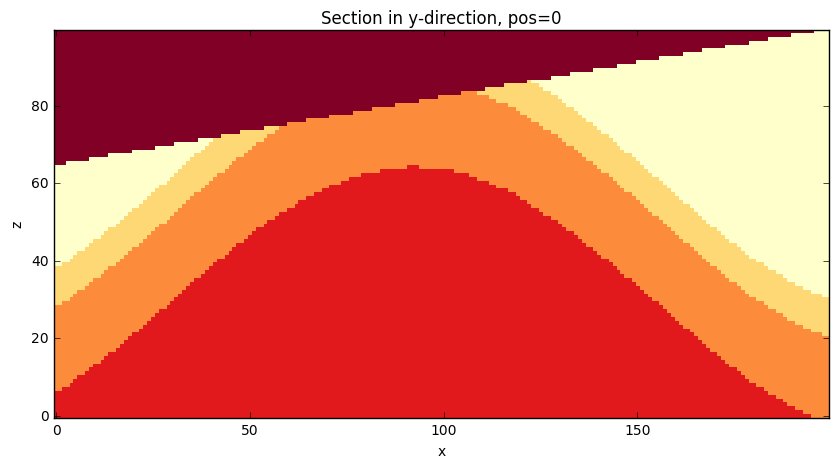

In [5]:
nm = pynoddy.history.NoddyHistory()
nm.set_extent(2000.,20.,1000.)
# set model origin x,y,z
nm.set_origin(0.,0.,1000.)
# set model cube size
nm.change_cube_size(cs)

strati_options = {'num_layers' : 4,
                  'layer_names' : ['4','3','2','1'],
                  'layer_thickness' : [0,300,220,100]} # is this actually the position/height of the layer boundary?!
nm.add_event('stratigraphy', strati_options )

tilt_options = {
    "name": "tilt1",
    "pos": (700,0,1000),
    "rotation": prior_dict["stratigraphy_rotation"]["mean"],
    "plunge_direction": 0.,
    "plunge": 0.
}

nm.add_event("tilt", tilt_options)

fold_options = {
    "name": "fold1",
    "pos": (300,0,0),
    "amplitude": prior_dict["fold_amplitude"]["mean"],
    "wavelength": prior_dict["fold_wavelength"]["mean"],
    "dip": 90.,
    "dip_dir": 90.
}

nm.add_event("fold", fold_options)

unconf_options = {
    "name": "unfonf1",
    "pos": (0,0,prior_dict["unconformity_height"]["mean"]),
    "rotation": 0.,
    "dip_direction": 90.,
    "dip": prior_dict["unconformity_rotation"]["mean"],
    "num_layers": 1,
    "layer_names": ["a"],
    "layer_thickness": [700]
}

nm.add_event("unconformity", unconf_options)

nm.write_history(initial_history)
ex = pynoddy.experiment.Experiment(initial_history)
ex.plot_section("y")

# Generate GeMpy Priors

In [6]:
import PynoddyBlocks as pb
reload(pb);

In [7]:
pynoddy_mean_prior_block = ex.get_section().block
np.shape(pynoddy_mean_prior_block)

(200L, 1L, 100L)

In [8]:
pmp = pb.PynoddyBlocks(pynoddy_mean_prior_block)

x_pos = [10,30,140,160]
y_pos = [0]
x_pos_fol = [(x_pos[0],x_pos[1]),(x_pos[2],x_pos[3])]
y_pos_fol = [(0,0),(0,0)]

for layer in np.unique(pmp.block):
    if int(layer) is not 6:
        pmp.add_interface_multiple(x_pos,y_pos, int(layer))
        pmp.add_foliations_multiple(x_pos_fol,y_pos_fol, int(layer))

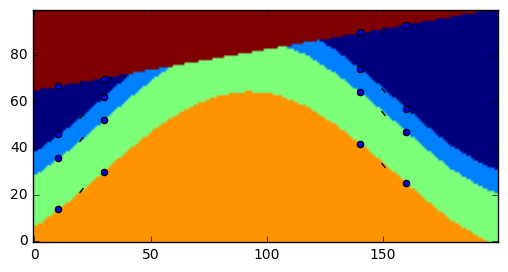

In [9]:
pmp.plot_points()

In [10]:
pmp.Interfaces

,X,Y,Z,formation
0,10.0,0.0,46.0,Layer1
1,30.0,0.0,62.0,Layer1
2,140.0,0.0,74.0,Layer1
3,160.0,0.0,57.0,Layer1
4,10.0,0.0,36.0,Layer2
5,30.0,0.0,52.0,Layer2
6,140.0,0.0,64.0,Layer2
7,160.0,0.0,47.0,Layer2
8,10.0,0.0,14.0,Layer3
9,30.0,0.0,30.0,Layer3


In [11]:
from __future__ import division
import copy

In [12]:
gempy_prior_dict = {}
for row in pmp.Interfaces.values:
    print row
    gempy_prior_dict[row[-1]+"_x"+str(int(row[0]))+"_y"+str(int(row[1]))] = {"X": row[0],
                                                                 "Y": row[1],
                                                                 "formation": row[-1],
                                                                 "Z": pymc.Normal(row[-1]+"_x"+str(int(row[0]))+"_y"+str(int(row[1])), row[2], 1./np.square(row[2]/5.))}
    

[10.0 0.0 46.0 'Layer1']
[30.0 0.0 62.0 'Layer1']
[140.0 0.0 74.0 'Layer1']
[160.0 0.0 57.0 'Layer1']
[10.0 0.0 36.0 'Layer2']
[30.0 0.0 52.0 'Layer2']
[140.0 0.0 64.0 'Layer2']
[160.0 0.0 47.0 'Layer2']
[10.0 0.0 14.0 'Layer3']
[30.0 0.0 30.0 'Layer3']
[140.0 0.0 42.0 'Layer3']
[160.0 0.0 25.0 'Layer3']
[10.0 0.0 67.0 'Layer5']
[30.0 0.0 70.0 'Layer5']
[140.0 0.0 90.0 'Layer5']
[160.0 0.0 93.0 'Layer5']


In [13]:
gempy_prior_dict

{'Layer1_x10_y0': {'X': 10.0,
  'Y': 0.0,
  'Z': <pymc.distributions.Normal 'Layer1_x10_y0' at 0x000000000D942748>,
  'formation': 'Layer1'},
 'Layer1_x140_y0': {'X': 140.0,
  'Y': 0.0,
  'Z': <pymc.distributions.Normal 'Layer1_x140_y0' at 0x000000000D942630>,
  'formation': 'Layer1'},
 'Layer1_x160_y0': {'X': 160.0,
  'Y': 0.0,
  'Z': <pymc.distributions.Normal 'Layer1_x160_y0' at 0x000000000D942828>,
  'formation': 'Layer1'},
 'Layer1_x30_y0': {'X': 30.0,
  'Y': 0.0,
  'Z': <pymc.distributions.Normal 'Layer1_x30_y0' at 0x000000000DB46BA8>,
  'formation': 'Layer1'},
 'Layer2_x10_y0': {'X': 10.0,
  'Y': 0.0,
  'Z': <pymc.distributions.Normal 'Layer2_x10_y0' at 0x000000000D942198>,
  'formation': 'Layer2'},
 'Layer2_x140_y0': {'X': 140.0,
  'Y': 0.0,
  'Z': <pymc.distributions.Normal 'Layer2_x140_y0' at 0x000000000D942BE0>,
  'formation': 'Layer2'},
 'Layer2_x160_y0': {'X': 160.0,
  'Y': 0.0,
  'Z': <pymc.distributions.Normal 'Layer2_x160_y0' at 0x000000000D9427F0>,
  'formation': 'Laye

# Initiate gempy model

In [14]:
GM = GeoMig.Interpolator(0,200,
                         0,10,
                         0,100,
                         u_grade=3)

# set grid resolution
GM.set_resolutions(200,4,100)
GM.create_regular_grid_3D()

# compile
GM.theano_compilation_3D()

C:\Users\lebobcrash\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: stack(*tensors) interface is deprecated, use stack(tensors, axis=0) instead.


# Utility Functions

TODO:
* make these functions neat, maybe use numpy instead of loops you shithead

In [15]:
def check_adjacency(layerA,layerB,topology):
    """
    Check for adjacency of the two layers A and B. Returns True if connected, else False. Function should hold true even for 
    very weird model realisations with unexpected edges.
    layerA,layerB: str like "003" for layer #3
    """
    adjacency = None
    for node in topology.graph.node.keys():
        if layerA in node:
            #print topology.graph.edge[node].keys()
            for edge in topology.graph.edge[node].keys():
                if layerB in edge:
                    #print topology.graph.edge[node][edge]
                    #print "Node ",layerA," and ",layerB," share an edge!"
                    adjacency = True
    if adjacency is True:
        return True
    else:
        return False

# PyMC Model Implementation

##### Deterministic Functions

* pynoddy_model
* pynoddy_topology
* gempy_model
* parameter_extraction

In [16]:
def calc_fol(x,z):
    dx = x[0] - x[1]
    dz = z[0] - z[1]
    dip = np.rad2deg(np.arctan(dz/float(dx)))
    return dip

In [17]:
reload(GeoMig)

<module 'GeoMig' from 'C:/Users/lebobcrash/Documents/GitHub/GeMpy/GeMpy\GeoMig.pyc'>

In [18]:
# create initial pynoddy experiment object
ex_mcmc = pynoddy.experiment.Experiment(initial_history)

# NODDY MODEL CALCULATION
@pymc.deterministic
def pynoddy_model(value=0,
                 stratigraphy_rotation=stratigraphy_rotation, 
                 fold_amplitude=fold_amplitude, 
                 fold_wavelength=fold_wavelength, 
                 layer2_height=layer2_height, 
                 layer3_height=layer3_height, 
                 unconformity_height=unconformity_height,
                 unconformity_rotation=unconformity_rotation,
                 ex=ex_mcmc, cs=cs, verbose=0):
    """
    Whoop-dee Whoop.
    """
    # modify event 1: stratigraphy
    for unit in ex.events[1].layers:
        if unit.properties["Unit Name"] == 2.0:
            unit.properties["Height"] = layer2_height
        elif unit.properties["Unit Name"] == 3.0:
            unit.properties["Height"] = layer3_height
    
    # modify event 2: rotation of stratigraphy
    ex.events[2].properties['Rotation'] = stratigraphy_rotation
    
    # modify event 3: fold
    ex.events[3].properties["Amplitude"] = fold_amplitude
    ex.events[3].properties["Wavelength"] = fold_wavelength

    # modify event 4: unconformity
    ex.events[4].properties["Z"] = unconformity_height
    ex.events[4].properties["Dip"] = unconformity_rotation
    
    # write history of modified experiment
    ex.write_history("pymc_history.his")
    # compute model with files necessary for topology analysis
    pynoddy.compute_model("pymc_history.his", "pymc_noddy_output", sim_type="TOPOLOGY")
    model = pynoddy.output.NoddyOutput("pymc_noddy_output")
    
    if verbose == 1:
        ex.plot_section("y")
    
    # return model section
    return model.block[:,:,:]

# TOPOLOGY CALCULATION
@pymc.deterministic
def pynoddy_topology(value=0, pynoddy_model=pynoddy_model):
    # compute topology
    pynoddy.compute_topology("pymc_noddy_output", topology_path="topology.exe", type="TOPOLOGY");

    # load computed topology output
    topology = pynoddy.output.NoddyTopology("pymc_noddy_output")

    #return topology object
    return topology

@pymc.deterministic
def parameter_extraction(value=0, pynoddy_model=pynoddy_model, verbose=0):
    # extract relevant points from pynoddy
    extract = pb.PynoddyBlocks(pynoddy_model)
    
    x_pos = [20,110,170]
    y_pos = [0]
    x_pos_fol = [(x_pos[0],x_pos[1]),(x_pos[1],x_pos[2])]
    y_pos_fol = [(0,0),(0,0)]

    for layer in [1., 5.]:
        extract.add_interface_multiple(x_pos,y_pos, int(layer))
        extract.add_foliations_multiple(x_pos_fol,y_pos_fol, int(layer))
    
    if verbose == 1:
        extract.plot_points()
        
    return extract

# GEMPY MODEL
@pymc.deterministic
def gempy_model(value=0, parameter_extraction=parameter_extraction, gpd=gempy_prior_dict, 
                x_pos=x_pos, y_pos=y_pos,
                verbose=2):
    
    _foliation_col_names = ["X", "Y", "Z", "azimuth", "dip", "polarity", "formation"]
    temp_fol = pn.DataFrame(columns=_foliation_col_names)
    _interfaces_col_names = ["X", "Y", "Z", "formation"]
    temp_interf = pn.DataFrame(columns=_interfaces_col_names)
    
    # print gempy_prior_dict
    
    # add drawn gempy priors to interfaces
    for key in gpd.keys():
        temp_interf.loc[len(temp_interf)] = [gpd[key]["X"], gpd[key]["Y"], float(gpd[key]["Z"]), gpd[key]["formation"]]
    
    
    
    dip_l1 = np.rad2deg(np.arctan((gpd["Layer1_x10_y0"]["Z"] - gpd["Layer1_x30_y0"]["Z"]) / float(10-30) ))
    dip_l2 = np.rad2deg(np.arctan((gpd["Layer2_x10_y0"]["Z"] - gpd["Layer2_x30_y0"]["Z"]) / float(10-30) ))
    dip_l3 = np.rad2deg(np.arctan((gpd["Layer3_x10_y0"]["Z"] - gpd["Layer3_x30_y0"]["Z"]) / float(10-30) ))
    dip_l5 = np.rad2deg(np.arctan((gpd["Layer5_x10_y0"]["Z"] - gpd["Layer5_x30_y0"]["Z"]) / float(10-30) ))
    
    dip2_l1 = np.rad2deg(np.arctan((gpd["Layer1_x140_y0"]["Z"] - gpd["Layer1_x160_y0"]["Z"]) / float(-20) ))
    dip2_l2 = np.rad2deg(np.arctan((gpd["Layer2_x140_y0"]["Z"] - gpd["Layer2_x160_y0"]["Z"]) / float(-20) ))
    dip2_l3 = np.rad2deg(np.arctan((gpd["Layer3_x140_y0"]["Z"] - gpd["Layer3_x160_y0"]["Z"]) / float(-20) ))
    dip2_l5 = np.rad2deg(np.arctan((gpd["Layer5_x140_y0"]["Z"] - gpd["Layer5_x160_y0"]["Z"]) / float(-20) ))
    
    temp_fol.loc[len(temp_fol)] = [20,0,gpd["Layer1_x10_y0"]["Z"] - gpd["Layer1_x30_y0"]["Z"], 90., dip_l1, 1., "Layer1"]
    temp_fol.loc[len(temp_fol)] = [20,0,gpd["Layer2_x10_y0"]["Z"] - gpd["Layer2_x30_y0"]["Z"], 90., dip_l1, 1., "Layer2"]
    temp_fol.loc[len(temp_fol)] = [20,0,gpd["Layer3_x10_y0"]["Z"] - gpd["Layer3_x30_y0"]["Z"], 90., dip_l1, 1., "Layer3"]
    temp_fol.loc[len(temp_fol)] = [20,0,gpd["Layer5_x10_y0"]["Z"] - gpd["Layer5_x30_y0"]["Z"], 90., dip_l1, 1., "Layer5"]
    
    temp_fol.loc[len(temp_fol)] = [150,0,gpd["Layer1_x140_y0"]["Z"] - gpd["Layer1_x160_y0"]["Z"], 180., dip_l1, 1., "Layer1"]
    temp_fol.loc[len(temp_fol)] = [150,0,gpd["Layer2_x140_y0"]["Z"] - gpd["Layer2_x160_y0"]["Z"], 180., dip_l1, 1., "Layer2"]
    temp_fol.loc[len(temp_fol)] = [150,0,gpd["Layer3_x140_y0"]["Z"] - gpd["Layer3_x160_y0"]["Z"], 180., dip_l1, 1., "Layer3"]
    temp_fol.loc[len(temp_fol)] = [150,0,gpd["Layer5_x140_y0"]["Z"] - gpd["Layer5_x160_y0"]["Z"], 180., dip_l1, 1., "Layer5"]
    
    #print parameter_extraction.Interfaces
    
    #temp_fol = temp_fol.append(parameter_extraction.Foliations)
    #temp_interf = temp_interf.append(parameter_extraction.Interfaces)
    
    if verbose == 1:
        print temp_fol
        print temp_interf
    
    # deliver pynoddy extract dataframes to the gempy model object
    #GM.load_data_pd("interfaces", temp_interf)
    #GM.load_data_pd("foliations", temp_fol)
    
    GM.load_data_pd_combined(temp_interf, temp_fol)
    
    # set series shit
    initial = []
    unconf = []
    for layer in GM.formations:
        if layer is "Layer5":
            unconf.append(layer)
        else:
            initial.append(layer)
    
    if verbose == 1:
        print "GM.formations: ",GM.formations
        print "Initial: ",initial
        print "Unconf: ",unconf
    
    if len(unconf) is 0:
        GM.set_series({"Initial": tuple(initial)})
    else:
        GM.set_series({"Initial": tuple(initial),
                       "Unconformity": "Layer5"
                      })

    GM.block.set_value(np.zeros_like(GM.grid[:,0]))

    # Compute the block
    if len(unconf) is 0:
        GM.compute_block_model([0], verbose = 0)
    else:
        GM.compute_block_model([0,1], verbose = 0)
    plot_block =  GM.block.get_value().reshape(200,4,100)
    
    if verbose > 0:
        plt.imshow(plot_block[:,2,:].T, origin="lower")
        plt.title("gempy model")
        plt.scatter(GM.Interfaces["X"],GM.Interfaces["Z"])    
    return plot_block[:,2,:]


LinAlgError: Singular matrix
Apply node that caused the error: MatrixInverse(IncSubtensor{Set;int32::, int64:int64:}.0)
Toposort index: 1081
Inputs types: [TensorType(float64, matrix)]
Inputs shapes: [(12L, 12L)]
Inputs strides: [(96L, 8L)]
Inputs values: ['not shown']
Inputs type_num: [12]
Outputs clients: [[dot(MatrixInverse.0, IncSubtensor{Set;int64:int64:}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "C:\Users\lebobcrash\Anaconda2\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\lebobcrash\Anaconda2\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\lebobcrash\Anaconda2\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\lebobcrash\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\lebobcrash\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py", line 2827, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\lebobcrash\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-2b627522765c>", line 11, in <module>
    GM.theano_compilation_3D()
  File "C:/Users/lebobcrash/Documents/GitHub/GeMpy/GeMpy\GeoMig.py", line 718, in theano_compilation_3D
    DK_parameters = T.dot(T.nlinalg.matrix_inverse(C_matrix), b)

Debugprint of the apply node: 
MatrixInverse [id A] <TensorType(float64, matrix)> ''   
 |IncSubtensor{Set;int32::, int64:int64:} [id B] <TensorType(float64, matrix)> ''   
   |IncSubtensor{Set;int32::, int64:int64:} [id C] <TensorType(float64, matrix)> ''   
   | |IncSubtensor{Set;int64:int64:, int32::} [id D] <TensorType(float64, matrix)> ''   
   | | |IncSubtensor{Set;int64:int64:, int64:int64:} [id E] <TensorType(float64, matrix)> ''   
   | | | |IncSubtensor{Set;int64:int64:, int64:int64:} [id F] <TensorType(float64, matrix)> ''   
   | | | | |IncSubtensor{Set;int64:int64:, int32::} [id G] <TensorType(float64, matrix)> ''   
   | | | | | |IncSubtensor{Set;int64:int64:, int64:int64:} [id H] <TensorType(float64, matrix)> ''   
   | | | | | | |IncSubtensor{Set;int64:int64:, int64:int64:} [id I] <TensorType(float64, matrix)> ''   
   | | | | | | | |Alloc [id J] <TensorType(float64, matrix)> ''   
   | | | | | | | | |TensorConstant{0.0} [id K] <TensorType(float64, scalar)>
   | | | | | | | | |Elemwise{add,no_inplace} [id L] <TensorType(int64, scalar)> ''   
   | | | | | | | | | |Elemwise{add,no_inplace} [id M] <TensorType(int64, scalar)> ''   
   | | | | | | | | | | |Elemwise{mul,no_inplace} [id N] <TensorType(int64, scalar)> ''   
   | | | | | | | | | | | |Subtensor{int64} [id O] <TensorType(int64, scalar)> ''   
   | | | | | | | | | | | | |Shape [id P] <TensorType(int64, vector)> ''   
   | | | | | | | | | | | | | |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | | | | | | | |Constant{0} [id R] <int64>
   | | | | | | | | | | | |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | | | | | | | |Subtensor{int64} [id T] <TensorType(int64, scalar)> ''   
   | | | | | | | | | |   |Shape [id U] <TensorType(int64, vector)> ''   
   | | | | | | | | | |   | |Rest of the points of the layers [id V] <TensorType(float64, matrix)>
   | | | | | | | | | |   |Constant{0} [id W] <int64>
   | | | | | | | | | |<TensorType(int32, scalar)> [id X] <TensorType(int32, scalar)>
   | | | | | | | | |Elemwise{add,no_inplace} [id L] <TensorType(int64, scalar)> ''   
   | | | | | | | |FillDiagonal [id Y] <TensorType(float64, matrix)> ''   
   | | | | | | | | |Elemwise{switch,no_inplace} [id Z] <TensorType(float64, matrix)> ''   
   | | | | | | | | | |Elemwise{eq,no_inplace} [id BA] <TensorType(bool, matrix)> ''   
   | | | | | | | | | | |Elemwise{Cast{float32}} [id BB] <TensorType(float32, matrix)> ''   
   | | | | | | | | | | | |Elemwise{sqrt,no_inplace} [id BC] <TensorType(float64, matrix)> ''   
   | | | | | | | | | | |   |Elemwise{sub,no_inplace} [id BD] <TensorType(float64, matrix)> ''   
   | | | | | | | | | | |     |Elemwise{add,no_inplace} [id BE] <TensorType(float64, matrix)> ''   
   | | | | | | | | | | |     | |Reshape{2} [id BF] <TensorType(float64, col)> ''   
   | | | | | | | | | | |     | | |Sum{axis=[1], acc_dtype=float64} [id BG] <TensorType(float64, vector)> ''   
   | | | | | | | | | | |     | | | |Elemwise{pow,no_inplace} [id BH] <TensorType(float64, matrix)> ''   
   | | | | | | | | | | |     | | |   |Reshape{2} [id BI] <TensorType(float64, matrix)> ''   
   | | | | | | | | | | |     | | |   | |InplaceDimShuffle{0,2,1,3} [id BJ] <TensorType(float64, (False, False, True, False))> ''   
   | | | | | | | | | | |     | | |   | | |Alloc [id BK] <TensorType(float64, (False, True, False, False))> ''   
   | | | | | | | | | | |     | | |   | |   |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | | | | | |     | | |   | |   |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | | | | | | | |     | | |   | |   |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | | | | | |     | | |   | |   |Subtensor{int64} [id BM] <TensorType(int64, scalar)> ''   
   | | | | | | | | | | |     | | |   | |   | |Shape [id BN] <TensorType(int64, vector)> ''   
   | | | | | | | | | | |     | | |   | |   | | |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | | | | | |     | | |   | |   | |Constant{0} [id BO] <int64>
   | | | | | | | | | | |     | | |   | |   |Subtensor{int64} [id BP] <TensorType(int64, scalar)> ''   
   | | | | | | | | | | |     | | |   | |     |Shape [id BQ] <TensorType(int64, vector)> ''   
   | | | | | | | | | | |     | | |   | |     | |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | | | | | |     | | |   | |     |Constant{1} [id BR] <int64>
   | | | | | | | | | | |     | | |   | |MakeVector{dtype='int64'} [id BS] <TensorType(int64, vector)> ''   
   | | | | | | | | | | |     | | |   |   |Elemwise{mul,no_inplace} [id BT] <TensorType(int64, scalar)> ''   
   | | | | | | | | | | |     | | |   |   | |Subtensor{int64} [id BM] <TensorType(int64, scalar)> ''   
   | | | | | | | | | | |     | | |   |   | |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | | | | | | | |     | | |   |   |Elemwise{mul,no_inplace} [id BU] <TensorType(int64, scalar)> ''   
   | | | | | | | | | | |     | | |   |     |Subtensor{int64} [id BP] <TensorType(int64, scalar)> ''   
   | | | | | | | | | | |     | | |   |     |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | | | | | |     | | |   |InplaceDimShuffle{x,x} [id BV] <TensorType(int8, (True, True))> ''   
   | | | | | | | | | | |     | | |     |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | | | | | | | |     | | |MakeVector{dtype='int64'} [id BX] <TensorType(int64, vector)> ''   
   | | | | | | | | | | |     | |   |Subtensor{int64} [id BY] <TensorType(int64, scalar)> ''   
   | | | | | | | | | | |     | |   | |Shape [id BZ] <TensorType(int64, vector)> ''   
   | | | | | | | | | | |     | |   | | |Reshape{2} [id BI] <TensorType(float64, matrix)> ''   
   | | | | | | | | | | |     | |   | |Constant{0} [id CA] <int64>
   | | | | | | | | | | |     | |   |Elemwise{Cast{int64}} [id CB] <TensorType(int64, scalar)> ''   
   | | | | | | | | | | |     | |     |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | | | | | |     | |Reshape{2} [id CC] <TensorType(float64, row)> ''   
   | | | | | | | | | | |     |   |Sum{axis=[1], acc_dtype=float64} [id CD] <TensorType(float64, vector)> ''   
   | | | | | | | | | | |     |   | |Elemwise{pow,no_inplace} [id CE] <TensorType(float64, matrix)> ''   
   | | | | | | | | | | |     |   |   |Reshape{2} [id BI] <TensorType(float64, matrix)> ''   
   | | | | | | | | | | |     |   |   |InplaceDimShuffle{x,x} [id CF] <TensorType(int8, (True, True))> ''   
   | | | | | | | | | | |     |   |     |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | | | | | | | |     |   |MakeVector{dtype='int64'} [id CG] <TensorType(int64, vector)> ''   
   | | | | | | | | | | |     |     |Elemwise{Cast{int64}} [id CH] <TensorType(int64, scalar)> ''   
   | | | | | | | | | | |     |     | |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | | | | | |     |     |Subtensor{int64} [id CI] <TensorType(int64, scalar)> ''   
   | | | | | | | | | | |     |       |Shape [id CJ] <TensorType(int64, vector)> ''   
   | | | | | | | | | | |     |       | |Reshape{2} [id BI] <TensorType(float64, matrix)> ''   
   | | | | | | | | | | |     |       |Constant{0} [id CK] <int64>
   | | | | | | | | | | |     |Elemwise{mul,no_inplace} [id CL] <TensorType(float64, matrix)> ''   
   | | | | | | | | | | |       |InplaceDimShuffle{x,x} [id CM] <TensorType(int8, (True, True))> ''   
   | | | | | | | | | | |       | |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | | | | | | | |       |dot [id CN] <TensorType(float64, matrix)> ''   
   | | | | | | | | | | |         |Reshape{2} [id BI] <TensorType(float64, matrix)> ''   
   | | | | | | | | | | |         |InplaceDimShuffle{1,0} [id CO] <TensorType(float64, matrix)> ''   
   | | | | | | | | | | |           |Reshape{2} [id BI] <TensorType(float64, matrix)> ''   
   | | | | | | | | | | |InplaceDimShuffle{x,x} [id CP] <TensorType(int8, (True, True))> ''   
   | | | | | | | | | |   |TensorConstant{0} [id CQ] <TensorType(int8, scalar)>
   | | | | | | | | | |InplaceDimShuffle{x,x} [id CR] <TensorType(int8, (True, True))> ''   
   | | | | | | | | | | |TensorConstant{0} [id CQ] <TensorType(int8, scalar)>
   | | | | | | | | | |Elemwise{sub,no_inplace} [id CS] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   |Elemwise{mul,no_inplace} [id CT] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   | |Elemwise{true_div,no_inplace} [id CU] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   | | |Elemwise{mul,no_inplace} [id CV] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   | | | |Join [id CW] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   | | | | |TensorConstant{0} [id CQ] <TensorType(int8, scalar)>
   | | | | | | | | |   | | | | |Reshape{2} [id CX] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   | | | | | |InplaceDimShuffle{0,2,1,3} [id CY] <TensorType(float64, (True, False, False, False))> ''   
   | | | | | | | | |   | | | | | | |Alloc [id CZ] <TensorType(float64, (True, False, False, False))> ''   
   | | | | | | | | |   | | | | | |   |Elemwise{sub,no_inplace} [id DA] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   | | | | | |   | |InplaceDimShuffle{x,0} [id DB] <TensorType(float64, row)> ''   
   | | | | | | | | |   | | | | | |   | | |Subtensor{::, int64} [id DC] <TensorType(float64, vector)> ''   
   | | | | | | | | |   | | | | | |   | |   |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | | | |   | | | | | |   | |   |Constant{0} [id DD] <int64>
   | | | | | | | | |   | | | | | |   | |Reshape{2} [id DE] <TensorType(float64, col)> ''   
   | | | | | | | | |   | | | | | |   |   |Subtensor{::, int64} [id DF] <TensorType(float64, vector)> ''   
   | | | | | | | | |   | | | | | |   |   | |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | | | |   | | | | | |   |   | |Constant{0} [id DG] <int64>
   | | | | | | | | |   | | | | | |   |   |MakeVector{dtype='int64'} [id DH] <TensorType(int64, vector)> ''   
   | | | | | | | | |   | | | | | |   |     |Subtensor{int64} [id DI] <TensorType(int64, scalar)> ''   
   | | | | | | | | |   | | | | | |   |     | |Shape [id DJ] <TensorType(int64, vector)> ''   
   | | | | | | | | |   | | | | | |   |     | | |Subtensor{::, int64} [id DK] <TensorType(float64, vector)> ''   
   | | | | | | | | |   | | | | | |   |     | |   |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | | | |   | | | | | |   |     | |   |Constant{0} [id DL] <int64>
   | | | | | | | | |   | | | | | |   |     | |Constant{0} [id DM] <int64>
   | | | | | | | | |   | | | | | |   |     |Elemwise{Cast{int64}} [id DN] <TensorType(int64, scalar)> ''   
   | | | | | | | | |   | | | | | |   |       |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | | | |   | | | | | |   |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | | | |   | | | | | |   |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | | | | | |   | | | | | |   |Subtensor{int64} [id DO] <TensorType(int64, scalar)> ''   
   | | | | | | | | |   | | | | | |   | |Shape [id DP] <TensorType(int64, vector)> ''   
   | | | | | | | | |   | | | | | |   | | |Elemwise{sub,no_inplace} [id DA] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   | | | | | |   | |Constant{0} [id DQ] <int64>
   | | | | | | | | |   | | | | | |   |Subtensor{int64} [id DR] <TensorType(int64, scalar)> ''   
   | | | | | | | | |   | | | | | |     |Shape [id DS] <TensorType(int64, vector)> ''   
   | | | | | | | | |   | | | | | |     | |Elemwise{sub,no_inplace} [id DA] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   | | | | | |     |Constant{1} [id DT] <int64>
   | | | | | | | | |   | | | | | |MakeVector{dtype='int64'} [id DU] <TensorType(int64, vector)> ''   
   | | | | | | | | |   | | | | |   |Elemwise{mul,no_inplace} [id DV] <TensorType(int64, scalar)> ''   
   | | | | | | | | |   | | | | |   | |Subtensor{int64} [id DO] <TensorType(int64, scalar)> ''   
   | | | | | | | | |   | | | | |   | |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | | | |   | | | | |   |Elemwise{mul,no_inplace} [id DW] <TensorType(int64, scalar)> ''   
   | | | | | | | | |   | | | | |     |Subtensor{int64} [id DR] <TensorType(int64, scalar)> ''   
   | | | | | | | | |   | | | | |     |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | | | | | |   | | | | |Reshape{2} [id DX] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   | | | | | |InplaceDimShuffle{0,2,1,3} [id DY] <TensorType(float64, (True, False, False, False))> ''   
   | | | | | | | | |   | | | | | | |Alloc [id DZ] <TensorType(float64, (True, False, False, False))> ''   
   | | | | | | | | |   | | | | | |   |Elemwise{sub,no_inplace} [id EA] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   | | | | | |   | |InplaceDimShuffle{x,0} [id EB] <TensorType(float64, row)> ''   
   | | | | | | | | |   | | | | | |   | | |Subtensor{::, int64} [id EC] <TensorType(float64, vector)> ''   
   | | | | | | | | |   | | | | | |   | |   |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | | | |   | | | | | |   | |   |Constant{1} [id ED] <int64>
   | | | | | | | | |   | | | | | |   | |Reshape{2} [id EE] <TensorType(float64, col)> ''   
   | | | | | | | | |   | | | | | |   |   |Subtensor{::, int64} [id EF] <TensorType(float64, vector)> ''   
   | | | | | | | | |   | | | | | |   |   | |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | | | |   | | | | | |   |   | |Constant{1} [id EG] <int64>
   | | | | | | | | |   | | | | | |   |   |MakeVector{dtype='int64'} [id EH] <TensorType(int64, vector)> ''   
   | | | | | | | | |   | | | | | |   |     |Subtensor{int64} [id EI] <TensorType(int64, scalar)> ''   
   | | | | | | | | |   | | | | | |   |     | |Shape [id EJ] <TensorType(int64, vector)> ''   
   | | | | | | | | |   | | | | | |   |     | | |Subtensor{::, int64} [id EK] <TensorType(float64, vector)> ''   
   | | | | | | | | |   | | | | | |   |     | |   |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | | | |   | | | | | |   |     | |   |Constant{1} [id EL] <int64>
   | | | | | | | | |   | | | | | |   |     | |Constant{0} [id EM] <int64>
   | | | | | | | | |   | | | | | |   |     |Elemwise{Cast{int64}} [id EN] <TensorType(int64, scalar)> ''   
   | | | | | | | | |   | | | | | |   |       |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | | | |   | | | | | |   |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | | | |   | | | | | |   |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | | | | | |   | | | | | |   |Subtensor{int64} [id EO] <TensorType(int64, scalar)> ''   
   | | | | | | | | |   | | | | | |   | |Shape [id EP] <TensorType(int64, vector)> ''   
   | | | | | | | | |   | | | | | |   | | |Elemwise{sub,no_inplace} [id EA] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   | | | | | |   | |Constant{0} [id EQ] <int64>
   | | | | | | | | |   | | | | | |   |Subtensor{int64} [id ER] <TensorType(int64, scalar)> ''   
   | | | | | | | | |   | | | | | |     |Shape [id ES] <TensorType(int64, vector)> ''   
   | | | | | | | | |   | | | | | |     | |Elemwise{sub,no_inplace} [id EA] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   | | | | | |     |Constant{1} [id ET] <int64>
   | | | | | | | | |   | | | | | |MakeVector{dtype='int64'} [id EU] <TensorType(int64, vector)> ''   
   | | | | | | | | |   | | | | |   |Elemwise{mul,no_inplace} [id EV] <TensorType(int64, scalar)> ''   
   | | | | | | | | |   | | | | |   | |Subtensor{int64} [id EO] <TensorType(int64, scalar)> ''   
   | | | | | | | | |   | | | | |   | |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | | | |   | | | | |   |Elemwise{mul,no_inplace} [id EW] <TensorType(int64, scalar)> ''   
   | | | | | | | | |   | | | | |     |Subtensor{int64} [id ER] <TensorType(int64, scalar)> ''   
   | | | | | | | | |   | | | | |     |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | | | | | |   | | | | |Reshape{2} [id EX] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   | | | |   |InplaceDimShuffle{0,2,1,3} [id EY] <TensorType(float64, (True, False, False, False))> ''   
   | | | | | | | | |   | | | |   | |Alloc [id EZ] <TensorType(float64, (True, False, False, False))> ''   
   | | | | | | | | |   | | | |   |   |Elemwise{sub,no_inplace} [id FA] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   | | | |   |   | |InplaceDimShuffle{x,0} [id FB] <TensorType(float64, row)> ''   
   | | | | | | | | |   | | | |   |   | | |Subtensor{::, int64} [id FC] <TensorType(float64, vector)> ''   
   | | | | | | | | |   | | | |   |   | |   |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | | | |   | | | |   |   | |   |Constant{2} [id FD] <int64>
   | | | | | | | | |   | | | |   |   | |Reshape{2} [id FE] <TensorType(float64, col)> ''   
   | | | | | | | | |   | | | |   |   |   |Subtensor{::, int64} [id FF] <TensorType(float64, vector)> ''   
   | | | | | | | | |   | | | |   |   |   | |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | | | |   | | | |   |   |   | |Constant{2} [id FG] <int64>
   | | | | | | | | |   | | | |   |   |   |MakeVector{dtype='int64'} [id FH] <TensorType(int64, vector)> ''   
   | | | | | | | | |   | | | |   |   |     |Subtensor{int64} [id FI] <TensorType(int64, scalar)> ''   
   | | | | | | | | |   | | | |   |   |     | |Shape [id FJ] <TensorType(int64, vector)> ''   
   | | | | | | | | |   | | | |   |   |     | | |Subtensor{::, int64} [id FK] <TensorType(float64, vector)> ''   
   | | | | | | | | |   | | | |   |   |     | |   |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | | | |   | | | |   |   |     | |   |Constant{2} [id FL] <int64>
   | | | | | | | | |   | | | |   |   |     | |Constant{0} [id FM] <int64>
   | | | | | | | | |   | | | |   |   |     |Elemwise{Cast{int64}} [id FN] <TensorType(int64, scalar)> ''   
   | | | | | | | | |   | | | |   |   |       |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | | | |   | | | |   |   |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | | | |   | | | |   |   |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | | | | | |   | | | |   |   |Subtensor{int64} [id FO] <TensorType(int64, scalar)> ''   
   | | | | | | | | |   | | | |   |   | |Shape [id FP] <TensorType(int64, vector)> ''   
   | | | | | | | | |   | | | |   |   | | |Elemwise{sub,no_inplace} [id FA] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   | | | |   |   | |Constant{0} [id FQ] <int64>
   | | | | | | | | |   | | | |   |   |Subtensor{int64} [id FR] <TensorType(int64, scalar)> ''   
   | | | | | | | | |   | | | |   |     |Shape [id FS] <TensorType(int64, vector)> ''   
   | | | | | | | | |   | | | |   |     | |Elemwise{sub,no_inplace} [id FA] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   | | | |   |     |Constant{1} [id FT] <int64>
   | | | | | | | | |   | | | |   |MakeVector{dtype='int64'} [id FU] <TensorType(int64, vector)> ''   
   | | | | | | | | |   | | | |     |Elemwise{mul,no_inplace} [id FV] <TensorType(int64, scalar)> ''   
   | | | | | | | | |   | | | |     | |Subtensor{int64} [id FO] <TensorType(int64, scalar)> ''   
   | | | | | | | | |   | | | |     | |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | | | |   | | | |     |Elemwise{mul,no_inplace} [id FW] <TensorType(int64, scalar)> ''   
   | | | | | | | | |   | | | |       |Subtensor{int64} [id FR] <TensorType(int64, scalar)> ''   
   | | | | | | | | |   | | | |       |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | | | | | |   | | | |InplaceDimShuffle{1,0} [id FX] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   | | |   |Join [id CW] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   | | |Elemwise{pow,no_inplace} [id FY] <TensorType(float32, matrix)> ''   
   | | | | | | | | |   | |   |Elemwise{Cast{float32}} [id BB] <TensorType(float32, matrix)> ''   
   | | | | | | | | |   | |   |InplaceDimShuffle{x,x} [id FZ] <TensorType(int8, (True, True))> ''   
   | | | | | | | | |   | |     |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | | | | | |   | |Elemwise{add,no_inplace} [id GA] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   |   |Elemwise{mul,no_inplace} [id GB] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   |   | |Elemwise{lt,no_inplace} [id GC] <TensorType(bool, matrix)> ''   
   | | | | | | | | |   |   | | |Elemwise{Cast{float32}} [id BB] <TensorType(float32, matrix)> ''   
   | | | | | | | | |   |   | | |InplaceDimShuffle{x,x} [id GD] <TensorType(float64, (True, True))> ''   
   | | | | | | | | |   |   | |   |range [id GE] <TensorType(float64, scalar)>
   | | | | | | | | |   |   | |Elemwise{mul,no_inplace} [id GF] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   |   |   |InplaceDimShuffle{x,x} [id GG] <TensorType(float64, (True, True))> ''   
   | | | | | | | | |   |   |   | |Elemwise{neg,no_inplace} [id GH] <TensorType(float64, scalar)> ''   
   | | | | | | | | |   |   |   |   |covariance at 0 [id GI] <TensorType(float64, scalar)>
   | | | | | | | | |   |   |   |Elemwise{add,no_inplace} [id GJ] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   |   |     |Elemwise{sub,no_inplace} [id GK] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   |   |     | |Elemwise{add,no_inplace} [id GL] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   |   |     | | |InplaceDimShuffle{x,x} [id GM] <TensorType(float64, (True, True))> ''   
   | | | | | | | | |   |   |     | | | |Elemwise{true_div,no_inplace} [id GN] <TensorType(float64, scalar)> ''   
   | | | | | | | | |   |   |     | | |   |TensorConstant{-14} [id GO] <TensorType(int8, scalar)>
   | | | | | | | | |   |   |     | | |   |Elemwise{pow,no_inplace} [id GP] <TensorType(float64, scalar)> ''   
   | | | | | | | | |   |   |     | | |     |range [id GE] <TensorType(float64, scalar)>
   | | | | | | | | |   |   |     | | |     |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | | | | | |   |   |     | | |Elemwise{true_div,no_inplace} [id GQ] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   |   |     | |   |Elemwise{mul,no_inplace} [id GR] <TensorType(float32, matrix)> ''   
   | | | | | | | | |   |   |     | |   | |InplaceDimShuffle{x,x} [id GS] <TensorType(float32, (True, True))> ''   
   | | | | | | | | |   |   |     | |   | | |TensorConstant{26.25} [id GT] <TensorType(float32, scalar)>
   | | | | | | | | |   |   |     | |   | |Elemwise{Cast{float32}} [id BB] <TensorType(float32, matrix)> ''   
   | | | | | | | | |   |   |     | |   |InplaceDimShuffle{x,x} [id GU] <TensorType(float64, (True, True))> ''   
   | | | | | | | | |   |   |     | |     |Elemwise{pow,no_inplace} [id GV] <TensorType(float64, scalar)> ''   
   | | | | | | | | |   |   |     | |       |range [id GE] <TensorType(float64, scalar)>
   | | | | | | | | |   |   |     | |       |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | | | | | |   |   |     | |Elemwise{true_div,no_inplace} [id GW] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   |   |     |   |Elemwise{mul,no_inplace} [id GX] <TensorType(float32, matrix)> ''   
   | | | | | | | | |   |   |     |   | |InplaceDimShuffle{x,x} [id GY] <TensorType(float32, (True, True))> ''   
   | | | | | | | | |   |   |     |   | | |TensorConstant{17.5} [id GZ] <TensorType(float32, scalar)>
   | | | | | | | | |   |   |     |   | |Elemwise{pow,no_inplace} [id HA] <TensorType(float32, matrix)> ''   
   | | | | | | | | |   |   |     |   |   |Elemwise{Cast{float32}} [id BB] <TensorType(float32, matrix)> ''   
   | | | | | | | | |   |   |     |   |   |InplaceDimShuffle{x,x} [id HB] <TensorType(int8, (True, True))> ''   
   | | | | | | | | |   |   |     |   |     |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | | | | | |   |   |     |   |InplaceDimShuffle{x,x} [id HC] <TensorType(float64, (True, True))> ''   
   | | | | | | | | |   |   |     |     |Elemwise{pow,no_inplace} [id HD] <TensorType(float64, scalar)> ''   
   | | | | | | | | |   |   |     |       |range [id GE] <TensorType(float64, scalar)>
   | | | | | | | | |   |   |     |       |TensorConstant{5} [id HE] <TensorType(int8, scalar)>
   | | | | | | | | |   |   |     |Elemwise{true_div,no_inplace} [id HF] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   |   |       |Elemwise{mul,no_inplace} [id HG] <TensorType(float32, matrix)> ''   
   | | | | | | | | |   |   |       | |InplaceDimShuffle{x,x} [id HH] <TensorType(float32, (True, True))> ''   
   | | | | | | | | |   |   |       | | |TensorConstant{5.25} [id HI] <TensorType(float32, scalar)>
   | | | | | | | | |   |   |       | |Elemwise{pow,no_inplace} [id HJ] <TensorType(float32, matrix)> ''   
   | | | | | | | | |   |   |       |   |Elemwise{Cast{float32}} [id BB] <TensorType(float32, matrix)> ''   
   | | | | | | | | |   |   |       |   |InplaceDimShuffle{x,x} [id HK] <TensorType(int8, (True, True))> ''   
   | | | | | | | | |   |   |       |     |TensorConstant{5} [id HE] <TensorType(int8, scalar)>
   | | | | | | | | |   |   |       |InplaceDimShuffle{x,x} [id HL] <TensorType(float64, (True, True))> ''   
   | | | | | | | | |   |   |         |Elemwise{pow,no_inplace} [id HM] <TensorType(float64, scalar)> ''   
   | | | | | | | | |   |   |           |range [id GE] <TensorType(float64, scalar)>
   | | | | | | | | |   |   |           |TensorConstant{7} [id HN] <TensorType(int8, scalar)>
   | | | | | | | | |   |   |Elemwise{true_div,no_inplace} [id HO] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   |     |Elemwise{mul,no_inplace} [id HP] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   |     | |Elemwise{mul,no_inplace} [id HQ] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   |     | | |Elemwise{mul,no_inplace} [id HR] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   |     | | | |Elemwise{lt,no_inplace} [id HS] <TensorType(bool, matrix)> ''   
   | | | | | | | | |   |     | | | | |Elemwise{Cast{float32}} [id BB] <TensorType(float32, matrix)> ''   
   | | | | | | | | |   |     | | | | |InplaceDimShuffle{x,x} [id HT] <TensorType(float64, (True, True))> ''   
   | | | | | | | | |   |     | | | |   |range [id GE] <TensorType(float64, scalar)>
   | | | | | | | | |   |     | | | |InplaceDimShuffle{x,x} [id HU] <TensorType(float64, (True, True))> ''   
   | | | | | | | | |   |     | | |   |covariance at 0 [id GI] <TensorType(float64, scalar)>
   | | | | | | | | |   |     | | |InplaceDimShuffle{x,x} [id HV] <TensorType(int8, (True, True))> ''   
   | | | | | | | | |   |     | |   |TensorConstant{7} [id HN] <TensorType(int8, scalar)>
   | | | | | | | | |   |     | |Elemwise{sub,no_inplace} [id HW] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   |     |   |Elemwise{add,no_inplace} [id HX] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   |     |   | |Elemwise{sub,no_inplace} [id HY] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   |     |   | | |Elemwise{mul,no_inplace} [id HZ] <TensorType(float32, matrix)> ''   
   | | | | | | | | |   |     |   | | | |InplaceDimShuffle{x,x} [id IA] <TensorType(int8, (True, True))> ''   
   | | | | | | | | |   |     |   | | | | |TensorConstant{9} [id IB] <TensorType(int8, scalar)>
   | | | | | | | | |   |     |   | | | |Elemwise{pow,no_inplace} [id IC] <TensorType(float32, matrix)> ''   
   | | | | | | | | |   |     |   | | |   |Elemwise{Cast{float32}} [id BB] <TensorType(float32, matrix)> ''   
   | | | | | | | | |   |     |   | | |   |InplaceDimShuffle{x,x} [id ID] <TensorType(int8, (True, True))> ''   
   | | | | | | | | |   |     |   | | |     |TensorConstant{5} [id HE] <TensorType(int8, scalar)>
   | | | | | | | | |   |     |   | | |Elemwise{mul,no_inplace} [id IE] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   |     |   | |   |InplaceDimShuffle{x,x} [id IF] <TensorType(float64, (True, True))> ''   
   | | | | | | | | |   |     |   | |   | |Elemwise{mul,no_inplace} [id IG] <TensorType(float64, scalar)> ''   
   | | | | | | | | |   |     |   | |   |   |TensorConstant{20} [id IH] <TensorType(int8, scalar)>
   | | | | | | | | |   |     |   | |   |   |Elemwise{pow,no_inplace} [id II] <TensorType(float64, scalar)> ''   
   | | | | | | | | |   |     |   | |   |     |range [id GE] <TensorType(float64, scalar)>
   | | | | | | | | |   |     |   | |   |     |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | | | | | |   |     |   | |   |Elemwise{pow,no_inplace} [id IJ] <TensorType(float32, matrix)> ''   
   | | | | | | | | |   |     |   | |     |Elemwise{Cast{float32}} [id BB] <TensorType(float32, matrix)> ''   
   | | | | | | | | |   |     |   | |     |InplaceDimShuffle{x,x} [id IK] <TensorType(int8, (True, True))> ''   
   | | | | | | | | |   |     |   | |       |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | | | | | |   |     |   | |Elemwise{mul,no_inplace} [id IL] <TensorType(float64, matrix)> ''   
   | | | | | | | | |   |     |   |   |InplaceDimShuffle{x,x} [id IM] <TensorType(float64, (True, True))> ''   
   | | | | | | | | |   |     |   |   | |Elemwise{mul,no_inplace} [id IN] <TensorType(float64, scalar)> ''   
   | | | | | | | | |   |     |   |   |   |TensorConstant{15} [id IO] <TensorType(int8, scalar)>
   | | | | | | | | |   |     |   |   |   |Elemwise{pow,no_inplace} [id IP] <TensorType(float64, scalar)> ''   
   | | | | | | | | |   |     |   |   |     |range [id GE] <TensorType(float64, scalar)>
   | | | | | | | | |   |     |   |   |     |TensorConstant{4} [id IQ] <TensorType(int8, scalar)>
   | | | | | | | | |   |     |   |   |Elemwise{Cast{float32}} [id BB] <TensorType(float32, matrix)> ''   
   | | | | | | | | |   |     |   |InplaceDimShuffle{x,x} [id IR] <TensorType(float64, (True, True))> ''   
   | | | | | | | | |   |     |     |Elemwise{mul,no_inplace} [id IS] <TensorType(float64, scalar)> ''   
   | | | | | | | | |   |     |       |TensorConstant{4} [id IQ] <TensorType(int8, scalar)>
   | | | | | | | | |   |     |       |Elemwise{pow,no_inplace} [id IT] <TensorType(float64, scalar)> ''   
   | | | | | | | | |   |     |         |range [id GE] <TensorType(float64, scalar)>
   | | | | | | | | |   |     |         |TensorConstant{5} [id HE] <TensorType(int8, scalar)>
   | | | | | | | | |   |     |InplaceDimShuffle{x,x} [id IU] <TensorType(float64, (True, True))> ''   
   | | | | | | | | |   |       |Elemwise{mul,no_inplace} [id IV] <TensorType(float64, scalar)> ''   
   | | | | | | | | |   |         |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | | | | | |   |         |Elemwise{pow,no_inplace} [id IW] <TensorType(float64, scalar)> ''   
   | | | | | | | | |   |           |range [id GE] <TensorType(float64, scalar)>
   | | | | | | | | |   |           |TensorConstant{7} [id HN] <TensorType(int8, scalar)>
   | | | | | | | | |   |Elemwise{mul,no_inplace} [id IX] <TensorType(float64, matrix)> ''   
   | | | | | | | | |     |Elemwise{mul,no_inplace} [id IY] <TensorType(float64, matrix)> ''   
   | | | | | | | | |     | |Elemwise{mul,no_inplace} [id IZ] <TensorType(float32, matrix)> ''   
   | | | | | | | | |     | | |IncSubtensor{Set;int64:int64:, int64:int64:} [id JA] <TensorType(float32, matrix)> ''   
   | | | | | | | | |     | | | |IncSubtensor{Set;int64:int64:, int64:int64:} [id JB] <TensorType(float32, matrix)> ''   
   | | | | | | | | |     | | | | |IncSubtensor{Set;int64:int64:, int64:int64:} [id JC] <TensorType(float32, matrix)> ''   
   | | | | | | | | |     | | | | | |Elemwise{second,no_inplace} [id JD] <TensorType(float32, matrix)> ''   
   | | | | | | | | |     | | | | | | |Elemwise{Cast{float32}} [id BB] <TensorType(float32, matrix)> ''   
   | | | | | | | | |     | | | | | | |InplaceDimShuffle{x,x} [id JE] <TensorType(float32, (True, True))> ''   
   | | | | | | | | |     | | | | | |   |TensorConstant{0.0} [id JF] <TensorType(float32, scalar)>
   | | | | | | | | |     | | | | | |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | | | |     | | | | | |Constant{0} [id JG] <int64>
   | | | | | | | | |     | | | | | |ScalarFromTensor [id JH] <int64> ''   
   | | | | | | | | |     | | | | | | |Subtensor{int64} [id JI] <TensorType(int64, scalar)> ''   
   | | | | | | | | |     | | | | | |   |Shape [id JJ] <TensorType(int64, vector)> ''   
   | | | | | | | | |     | | | | | |   | |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | | | |     | | | | | |   |Constant{0} [id JK] <int64>
   | | | | | | | | |     | | | | | |Constant{0} [id JL] <int64>
   | | | | | | | | |     | | | | | |ScalarFromTensor [id JM] <int64> ''   
   | | | | | | | | |     | | | | |   |Subtensor{int64} [id JN] <TensorType(int64, scalar)> ''   
   | | | | | | | | |     | | | | |     |Shape [id JO] <TensorType(int64, vector)> ''   
   | | | | | | | | |     | | | | |     | |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | | | |     | | | | |     |Constant{0} [id JP] <int64>
   | | | | | | | | |     | | | | |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | | | |     | | | | |ScalarFromTensor [id JQ] <int64> ''   
   | | | | | | | | |     | | | | | |Subtensor{int64} [id JR] <TensorType(int64, scalar)> ''   
   | | | | | | | | |     | | | | |   |Shape [id JS] <TensorType(int64, vector)> ''   
   | | | | | | | | |     | | | | |   | |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | | | |     | | | | |   |Constant{0} [id JT] <int64>
   | | | | | | | | |     | | | | |ScalarFromTensor [id JU] <int64> ''   
   | | | | | | | | |     | | | | | |Elemwise{mul,no_inplace} [id JV] <TensorType(int64, scalar)> ''   
   | | | | | | | | |     | | | | |   |Subtensor{int64} [id JW] <TensorType(int64, scalar)> ''   
   | | | | | | | | |     | | | | |   | |Shape [id JX] <TensorType(int64, vector)> ''   
   | | | | | | | | |     | | | | |   | | |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | | | |     | | | | |   | |Constant{0} [id JY] <int64>
   | | | | | | | | |     | | | | |   |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | | | | | |     | | | | |ScalarFromTensor [id JZ] <int64> ''   
   | | | | | | | | |     | | | | | |Subtensor{int64} [id KA] <TensorType(int64, scalar)> ''   
   | | | | | | | | |     | | | | |   |Shape [id KB] <TensorType(int64, vector)> ''   
   | | | | | | | | |     | | | | |   | |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | | | |     | | | | |   |Constant{0} [id KC] <int64>
   | | | | | | | | |     | | | | |ScalarFromTensor [id KD] <int64> ''   
   | | | | | | | | |     | | | |   |Elemwise{mul,no_inplace} [id KE] <TensorType(int64, scalar)> ''   
   | | | | | | | | |     | | | |     |Subtensor{int64} [id KF] <TensorType(int64, scalar)> ''   
   | | | | | | | | |     | | | |     | |Shape [id KG] <TensorType(int64, vector)> ''   
   | | | | | | | | |     | | | |     | | |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | | | |     | | | |     | |Constant{0} [id KH] <int64>
   | | | | | | | | |     | | | |     |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | | | | | |     | | | |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | | | |     | | | |ScalarFromTensor [id KI] <int64> ''   
   | | | | | | | | |     | | | | |Elemwise{mul,no_inplace} [id KJ] <TensorType(int64, scalar)> ''   
   | | | | | | | | |     | | | |   |Subtensor{int64} [id KK] <TensorType(int64, scalar)> ''   
   | | | | | | | | |     | | | |   | |Shape [id KL] <TensorType(int64, vector)> ''   
   | | | | | | | | |     | | | |   | | |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | | | |     | | | |   | |Constant{0} [id KM] <int64>
   | | | | | | | | |     | | | |   |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | | | | | |     | | | |ScalarFromTensor [id KN] <int64> ''   
   | | | | | | | | |     | | | | |Elemwise{mul,no_inplace} [id KO] <TensorType(int64, scalar)> ''   
   | | | | | | | | |     | | | |   |Subtensor{int64} [id KP] <TensorType(int64, scalar)> ''   
   | | | | | | | | |     | | | |   | |Shape [id KQ] <TensorType(int64, vector)> ''   
   | | | | | | | | |     | | | |   | | |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | | | |     | | | |   | |Constant{0} [id KR] <int64>
   | | | | | | | | |     | | | |   |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | | | | | |     | | | |ScalarFromTensor [id KS] <int64> ''   
   | | | | | | | | |     | | | | |Elemwise{mul,no_inplace} [id KT] <TensorType(int64, scalar)> ''   
   | | | | | | | | |     | | | |   |Subtensor{int64} [id KU] <TensorType(int64, scalar)> ''   
   | | | | | | | | |     | | | |   | |Shape [id KV] <TensorType(int64, vector)> ''   
   | | | | | | | | |     | | | |   | | |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | | | |     | | | |   | |Constant{0} [id KW] <int64>
   | | | | | | | | |     | | | |   |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | | | | | |     | | | |ScalarFromTensor [id KX] <int64> ''   
   | | | | | | | | |     | | |   |Elemwise{mul,no_inplace} [id KY] <TensorType(int64, scalar)> ''   
   | | | | | | | | |     | | |     |Subtensor{int64} [id KZ] <TensorType(int64, scalar)> ''   
   | | | | | | | | |     | | |     | |Shape [id LA] <TensorType(int64, vector)> ''   
   | | | | | | | | |     | | |     | | |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | | | |     | | |     | |Constant{0} [id LB] <int64>
   | | | | | | | | |     | | |     |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | | | | | |     | | |Elemwise{lt,no_inplace} [id LC] <TensorType(bool, matrix)> ''   
   | | | | | | | | |     | |   |Elemwise{Cast{float32}} [id BB] <TensorType(float32, matrix)> ''   
   | | | | | | | | |     | |   |InplaceDimShuffle{x,x} [id LD] <TensorType(float64, (True, True))> ''   
   | | | | | | | | |     | |     |range [id GE] <TensorType(float64, scalar)>
   | | | | | | | | |     | |InplaceDimShuffle{x,x} [id LE] <TensorType(float64, (True, True))> ''   
   | | | | | | | | |     |   |covariance at 0 [id GI] <TensorType(float64, scalar)>
   | | | | | | | | |     |Elemwise{add,no_inplace} [id LF] <TensorType(float64, matrix)> ''   
   | | | | | | | | |       |Elemwise{sub,no_inplace} [id LG] <TensorType(float64, matrix)> ''   
   | | | | | | | | |       | |Elemwise{add,no_inplace} [id LH] <TensorType(float64, matrix)> ''   
   | | | | | | | | |       | | |InplaceDimShuffle{x,x} [id LI] <TensorType(float64, (True, True))> ''   
   | | | | | | | | |       | | | |Elemwise{true_div,no_inplace} [id LJ] <TensorType(float64, scalar)> ''   
   | | | | | | | | |       | | |   |TensorConstant{-14} [id LK] <TensorType(int8, scalar)>
   | | | | | | | | |       | | |   |Elemwise{pow,no_inplace} [id LL] <TensorType(float64, scalar)> ''   
   | | | | | | | | |       | | |     |range [id GE] <TensorType(float64, scalar)>
   | | | | | | | | |       | | |     |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | | | | | |       | | |Elemwise{true_div,no_inplace} [id LM] <TensorType(float64, matrix)> ''   
   | | | | | | | | |       | |   |Elemwise{mul,no_inplace} [id LN] <TensorType(float32, matrix)> ''   
   | | | | | | | | |       | |   | |InplaceDimShuffle{x,x} [id LO] <TensorType(float32, (True, True))> ''   
   | | | | | | | | |       | |   | | |TensorConstant{26.25} [id LP] <TensorType(float32, scalar)>
   | | | | | | | | |       | |   | |Elemwise{Cast{float32}} [id BB] <TensorType(float32, matrix)> ''   
   | | | | | | | | |       | |   |InplaceDimShuffle{x,x} [id LQ] <TensorType(float64, (True, True))> ''   
   | | | | | | | | |       | |     |Elemwise{pow,no_inplace} [id LR] <TensorType(float64, scalar)> ''   
   | | | | | | | | |       | |       |range [id GE] <TensorType(float64, scalar)>
   | | | | | | | | |       | |       |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | | | | | |       | |Elemwise{true_div,no_inplace} [id LS] <TensorType(float64, matrix)> ''   
   | | | | | | | | |       |   |Elemwise{mul,no_inplace} [id LT] <TensorType(float32, matrix)> ''   
   | | | | | | | | |       |   | |InplaceDimShuffle{x,x} [id LU] <TensorType(float32, (True, True))> ''   
   | | | | | | | | |       |   | | |TensorConstant{17.5} [id LV] <TensorType(float32, scalar)>
   | | | | | | | | |       |   | |Elemwise{pow,no_inplace} [id LW] <TensorType(float32, matrix)> ''   
   | | | | | | | | |       |   |   |Elemwise{Cast{float32}} [id BB] <TensorType(float32, matrix)> ''   
   | | | | | | | | |       |   |   |InplaceDimShuffle{x,x} [id LX] <TensorType(int8, (True, True))> ''   
   | | | | | | | | |       |   |     |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | | | | | |       |   |InplaceDimShuffle{x,x} [id LY] <TensorType(float64, (True, True))> ''   
   | | | | | | | | |       |     |Elemwise{pow,no_inplace} [id LZ] <TensorType(float64, scalar)> ''   
   | | | | | | | | |       |       |range [id GE] <TensorType(float64, scalar)>
   | | | | | | | | |       |       |TensorConstant{5} [id HE] <TensorType(int8, scalar)>
   | | | | | | | | |       |Elemwise{true_div,no_inplace} [id MA] <TensorType(float64, matrix)> ''   
   | | | | | | | | |         |Elemwise{mul,no_inplace} [id MB] <TensorType(float32, matrix)> ''   
   | | | | | | | | |         | |InplaceDimShuffle{x,x} [id MC] <TensorType(float32, (True, True))> ''   
   | | | | | | | | |         | | |TensorConstant{5.25} [id MD] <TensorType(float32, scalar)>
   | | | | | | | | |         | |Elemwise{pow,no_inplace} [id ME] <TensorType(float32, matrix)> ''   
   | | | | | | | | |         |   |Elemwise{Cast{float32}} [id BB] <TensorType(float32, matrix)> ''   
   | | | | | | | | |         |   |InplaceDimShuffle{x,x} [id MF] <TensorType(int8, (True, True))> ''   
   | | | | | | | | |         |     |TensorConstant{5} [id HE] <TensorType(int8, scalar)>
   | | | | | | | | |         |InplaceDimShuffle{x,x} [id MG] <TensorType(float64, (True, True))> ''   
   | | | | | | | | |           |Elemwise{pow,no_inplace} [id MH] <TensorType(float64, scalar)> ''   
   | | | | | | | | |             |range [id GE] <TensorType(float64, scalar)>
   | | | | | | | | |             |TensorConstant{7} [id HN] <TensorType(int8, scalar)>
   | | | | | | | | |Elemwise{add,no_inplace} [id MI] <TensorType(float64, scalar)> ''   
   | | | | | | | |   |Elemwise{mul,no_inplace} [id MJ] <TensorType(float64, scalar)> ''   
   | | | | | | | |   | |Elemwise{neg,no_inplace} [id MK] <TensorType(float64, scalar)> ''   
   | | | | | | | |   | | |covariance at 0 [id GI] <TensorType(float64, scalar)>
   | | | | | | | |   | |Elemwise{true_div,no_inplace} [id ML] <TensorType(float64, scalar)> ''   
   | | | | | | | |   |   |TensorConstant{-14} [id MM] <TensorType(int8, scalar)>
   | | | | | | | |   |   |Elemwise{pow,no_inplace} [id MN] <TensorType(float64, scalar)> ''   
   | | | | | | | |   |     |range [id GE] <TensorType(float64, scalar)>
   | | | | | | | |   |     |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | | | | |   |nugget effect of the grade [id MO] <TensorType(float64, scalar)>
   | | | | | | | |Constant{0} [id MP] <int64>
   | | | | | | | |ScalarFromTensor [id MQ] <int64> ''   
   | | | | | | | | |Elemwise{mul,no_inplace} [id N] <TensorType(int64, scalar)> ''   
   | | | | | | | |Constant{0} [id MR] <int64>
   | | | | | | | |ScalarFromTensor [id MS] <int64> ''   
   | | | | | | |   |Elemwise{mul,no_inplace} [id N] <TensorType(int64, scalar)> ''   
   | | | | | | |InplaceDimShuffle{1,0} [id MT] <TensorType(float64, matrix)> ''   
   | | | | | | | |Elemwise{mul,no_inplace} [id MU] <TensorType(float64, matrix)> ''   
   | | | | | | |   |InplaceDimShuffle{x,x} [id MV] <TensorType(float64, (True, True))> ''   
   | | | | | | |   | |Elemwise{true_div,no_inplace} [id MW] <TensorType(float64, scalar)> ''   
   | | | | | | |   |   |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | |   |   |rescaling factor [id MX] <TensorType(int32, scalar)>
   | | | | | | |   |InplaceDimShuffle{1,0} [id MY] <TensorType(float64, matrix)> ''   
   | | | | | | |     |Elemwise{sub,no_inplace} [id MZ] <TensorType(float64, matrix)> ''   
   | | | | | | |       |Elemwise{mul,no_inplace} [id NA] <TensorType(float64, matrix)> ''   
   | | | | | | |       | |Elemwise{mul,no_inplace} [id NB] <TensorType(float64, matrix)> ''   
   | | | | | | |       | | |Join [id NC] <TensorType(float64, matrix)> ''   
   | | | | | | |       | | | |TensorConstant{0} [id CQ] <TensorType(int8, scalar)>
   | | | | | | |       | | | |InplaceDimShuffle{1,0} [id ND] <TensorType(float64, matrix)> ''   
   | | | | | | |       | | | | |Elemwise{sub,no_inplace} [id NE] <TensorType(float64, matrix)> ''   
   | | | | | | |       | | | |   |InplaceDimShuffle{x,0} [id NF] <TensorType(float64, row)> ''   
   | | | | | | |       | | | |   | |Subtensor{::, int64} [id NG] <TensorType(float64, vector)> ''   
   | | | | | | |       | | | |   |   |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | |       | | | |   |   |Constant{0} [id NH] <int64>
   | | | | | | |       | | | |   |Reshape{2} [id NI] <TensorType(float64, col)> ''   
   | | | | | | |       | | | |     |Subtensor{::, int64} [id NJ] <TensorType(float64, vector)> ''   
   | | | | | | |       | | | |     | |Rest of the points of the layers [id V] <TensorType(float64, matrix)>
   | | | | | | |       | | | |     | |Constant{0} [id NK] <int64>
   | | | | | | |       | | | |     |MakeVector{dtype='int64'} [id NL] <TensorType(int64, vector)> ''   
   | | | | | | |       | | | |       |Subtensor{int64} [id NM] <TensorType(int64, scalar)> ''   
   | | | | | | |       | | | |       | |Shape [id NN] <TensorType(int64, vector)> ''   
   | | | | | | |       | | | |       | | |Subtensor{::, int64} [id NO] <TensorType(float64, vector)> ''   
   | | | | | | |       | | | |       | |   |Rest of the points of the layers [id V] <TensorType(float64, matrix)>
   | | | | | | |       | | | |       | |   |Constant{0} [id NP] <int64>
   | | | | | | |       | | | |       | |Constant{0} [id NQ] <int64>
   | | | | | | |       | | | |       |Elemwise{Cast{int64}} [id NR] <TensorType(int64, scalar)> ''   
   | | | | | | |       | | | |         |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | |       | | | |InplaceDimShuffle{1,0} [id NS] <TensorType(float64, matrix)> ''   
   | | | | | | |       | | | | |Elemwise{sub,no_inplace} [id NT] <TensorType(float64, matrix)> ''   
   | | | | | | |       | | | |   |InplaceDimShuffle{x,0} [id NU] <TensorType(float64, row)> ''   
   | | | | | | |       | | | |   | |Subtensor{::, int64} [id NV] <TensorType(float64, vector)> ''   
   | | | | | | |       | | | |   |   |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | |       | | | |   |   |Constant{1} [id NW] <int64>
   | | | | | | |       | | | |   |Reshape{2} [id NX] <TensorType(float64, col)> ''   
   | | | | | | |       | | | |     |Subtensor{::, int64} [id NY] <TensorType(float64, vector)> ''   
   | | | | | | |       | | | |     | |Rest of the points of the layers [id V] <TensorType(float64, matrix)>
   | | | | | | |       | | | |     | |Constant{1} [id NZ] <int64>
   | | | | | | |       | | | |     |MakeVector{dtype='int64'} [id OA] <TensorType(int64, vector)> ''   
   | | | | | | |       | | | |       |Subtensor{int64} [id OB] <TensorType(int64, scalar)> ''   
   | | | | | | |       | | | |       | |Shape [id OC] <TensorType(int64, vector)> ''   
   | | | | | | |       | | | |       | | |Subtensor{::, int64} [id OD] <TensorType(float64, vector)> ''   
   | | | | | | |       | | | |       | |   |Rest of the points of the layers [id V] <TensorType(float64, matrix)>
   | | | | | | |       | | | |       | |   |Constant{1} [id OE] <int64>
   | | | | | | |       | | | |       | |Constant{0} [id OF] <int64>
   | | | | | | |       | | | |       |Elemwise{Cast{int64}} [id OG] <TensorType(int64, scalar)> ''   
   | | | | | | |       | | | |         |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | |       | | | |InplaceDimShuffle{1,0} [id OH] <TensorType(float64, matrix)> ''   
   | | | | | | |       | | |   |Elemwise{sub,no_inplace} [id OI] <TensorType(float64, matrix)> ''   
   | | | | | | |       | | |     |InplaceDimShuffle{x,0} [id OJ] <TensorType(float64, row)> ''   
   | | | | | | |       | | |     | |Subtensor{::, int64} [id OK] <TensorType(float64, vector)> ''   
   | | | | | | |       | | |     |   |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | |       | | |     |   |Constant{2} [id OL] <int64>
   | | | | | | |       | | |     |Reshape{2} [id OM] <TensorType(float64, col)> ''   
   | | | | | | |       | | |       |Subtensor{::, int64} [id ON] <TensorType(float64, vector)> ''   
   | | | | | | |       | | |       | |Rest of the points of the layers [id V] <TensorType(float64, matrix)>
   | | | | | | |       | | |       | |Constant{2} [id OO] <int64>
   | | | | | | |       | | |       |MakeVector{dtype='int64'} [id OP] <TensorType(int64, vector)> ''   
   | | | | | | |       | | |         |Subtensor{int64} [id OQ] <TensorType(int64, scalar)> ''   
   | | | | | | |       | | |         | |Shape [id OR] <TensorType(int64, vector)> ''   
   | | | | | | |       | | |         | | |Subtensor{::, int64} [id OS] <TensorType(float64, vector)> ''   
   | | | | | | |       | | |         | |   |Rest of the points of the layers [id V] <TensorType(float64, matrix)>
   | | | | | | |       | | |         | |   |Constant{2} [id OT] <int64>
   | | | | | | |       | | |         | |Constant{0} [id OU] <int64>
   | | | | | | |       | | |         |Elemwise{Cast{int64}} [id OV] <TensorType(int64, scalar)> ''   
   | | | | | | |       | | |           |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | |       | | |Elemwise{lt,no_inplace} [id OW] <TensorType(bool, matrix)> ''   
   | | | | | | |       | |   |Elemwise{Cast{float32}} [id OX] <TensorType(float32, matrix)> ''   
   | | | | | | |       | |   | |Elemwise{sqrt,no_inplace} [id OY] <TensorType(float64, matrix)> ''   
   | | | | | | |       | |   |   |Elemwise{sub,no_inplace} [id OZ] <TensorType(float64, matrix)> ''   
   | | | | | | |       | |   |     |Elemwise{add,no_inplace} [id PA] <TensorType(float64, matrix)> ''   
   | | | | | | |       | |   |     | |Reshape{2} [id PB] <TensorType(float64, col)> ''   
   | | | | | | |       | |   |     | | |Sum{axis=[1], acc_dtype=float64} [id PC] <TensorType(float64, vector)> ''   
   | | | | | | |       | |   |     | | | |Elemwise{pow,no_inplace} [id PD] <TensorType(float64, matrix)> ''   
   | | | | | | |       | |   |     | | |   |Reshape{2} [id BI] <TensorType(float64, matrix)> ''   
   | | | | | | |       | |   |     | | |   |InplaceDimShuffle{x,x} [id PE] <TensorType(int8, (True, True))> ''   
   | | | | | | |       | |   |     | | |     |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | | | |       | |   |     | | |MakeVector{dtype='int64'} [id PF] <TensorType(int64, vector)> ''   
   | | | | | | |       | |   |     | |   |Subtensor{int64} [id PG] <TensorType(int64, scalar)> ''   
   | | | | | | |       | |   |     | |   | |Shape [id PH] <TensorType(int64, vector)> ''   
   | | | | | | |       | |   |     | |   | | |Reshape{2} [id BI] <TensorType(float64, matrix)> ''   
   | | | | | | |       | |   |     | |   | |Constant{0} [id PI] <int64>
   | | | | | | |       | |   |     | |   |Elemwise{Cast{int64}} [id PJ] <TensorType(int64, scalar)> ''   
   | | | | | | |       | |   |     | |     |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | |       | |   |     | |Reshape{2} [id PK] <TensorType(float64, row)> ''   
   | | | | | | |       | |   |     |   |Sum{axis=[1], acc_dtype=float64} [id PL] <TensorType(float64, vector)> ''   
   | | | | | | |       | |   |     |   | |Elemwise{pow,no_inplace} [id PM] <TensorType(float64, matrix)> ''   
   | | | | | | |       | |   |     |   |   |Rest of the points of the layers [id V] <TensorType(float64, matrix)>
   | | | | | | |       | |   |     |   |   |InplaceDimShuffle{x,x} [id PN] <TensorType(int8, (True, True))> ''   
   | | | | | | |       | |   |     |   |     |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | | | |       | |   |     |   |MakeVector{dtype='int64'} [id PO] <TensorType(int64, vector)> ''   
   | | | | | | |       | |   |     |     |Elemwise{Cast{int64}} [id PP] <TensorType(int64, scalar)> ''   
   | | | | | | |       | |   |     |     | |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | |       | |   |     |     |Subtensor{int64} [id PQ] <TensorType(int64, scalar)> ''   
   | | | | | | |       | |   |     |       |Shape [id PR] <TensorType(int64, vector)> ''   
   | | | | | | |       | |   |     |       | |Rest of the points of the layers [id V] <TensorType(float64, matrix)>
   | | | | | | |       | |   |     |       |Constant{0} [id PS] <int64>
   | | | | | | |       | |   |     |Elemwise{mul,no_inplace} [id PT] <TensorType(float64, matrix)> ''   
   | | | | | | |       | |   |       |InplaceDimShuffle{x,x} [id PU] <TensorType(int8, (True, True))> ''   
   | | | | | | |       | |   |       | |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | | | |       | |   |       |dot [id PV] <TensorType(float64, matrix)> ''   
   | | | | | | |       | |   |         |Reshape{2} [id BI] <TensorType(float64, matrix)> ''   
   | | | | | | |       | |   |         |InplaceDimShuffle{1,0} [id PW] <TensorType(float64, matrix)> 'Rest of the points of the layers.T'   
   | | | | | | |       | |   |InplaceDimShuffle{x,x} [id PX] <TensorType(float64, (True, True))> ''   
   | | | | | | |       | |     |range [id GE] <TensorType(float64, scalar)>
   | | | | | | |       | |Elemwise{mul,no_inplace} [id PY] <TensorType(float64, matrix)> ''   
   | | | | | | |       |   |InplaceDimShuffle{x,x} [id PZ] <TensorType(float64, (True, True))> ''   
   | | | | | | |       |   | |Elemwise{neg,no_inplace} [id QA] <TensorType(float64, scalar)> ''   
   | | | | | | |       |   |   |covariance at 0 [id GI] <TensorType(float64, scalar)>
   | | | | | | |       |   |Elemwise{add,no_inplace} [id QB] <TensorType(float64, matrix)> ''   
   | | | | | | |       |     |Elemwise{sub,no_inplace} [id QC] <TensorType(float64, matrix)> ''   
   | | | | | | |       |     | |Elemwise{add,no_inplace} [id QD] <TensorType(float64, matrix)> ''   
   | | | | | | |       |     | | |InplaceDimShuffle{x,x} [id QE] <TensorType(float64, (True, True))> ''   
   | | | | | | |       |     | | | |Elemwise{true_div,no_inplace} [id QF] <TensorType(float64, scalar)> ''   
   | | | | | | |       |     | | |   |TensorConstant{-14} [id QG] <TensorType(int8, scalar)>
   | | | | | | |       |     | | |   |Elemwise{pow,no_inplace} [id QH] <TensorType(float64, scalar)> ''   
   | | | | | | |       |     | | |     |range [id GE] <TensorType(float64, scalar)>
   | | | | | | |       |     | | |     |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | | | |       |     | | |Elemwise{true_div,no_inplace} [id QI] <TensorType(float64, matrix)> ''   
   | | | | | | |       |     | |   |Elemwise{mul,no_inplace} [id QJ] <TensorType(float32, matrix)> ''   
   | | | | | | |       |     | |   | |InplaceDimShuffle{x,x} [id QK] <TensorType(float32, (True, True))> ''   
   | | | | | | |       |     | |   | | |TensorConstant{26.25} [id QL] <TensorType(float32, scalar)>
   | | | | | | |       |     | |   | |Elemwise{Cast{float32}} [id OX] <TensorType(float32, matrix)> ''   
   | | | | | | |       |     | |   |InplaceDimShuffle{x,x} [id QM] <TensorType(float64, (True, True))> ''   
   | | | | | | |       |     | |     |Elemwise{pow,no_inplace} [id QN] <TensorType(float64, scalar)> ''   
   | | | | | | |       |     | |       |range [id GE] <TensorType(float64, scalar)>
   | | | | | | |       |     | |       |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | | | |       |     | |Elemwise{true_div,no_inplace} [id QO] <TensorType(float64, matrix)> ''   
   | | | | | | |       |     |   |Elemwise{mul,no_inplace} [id QP] <TensorType(float32, matrix)> ''   
   | | | | | | |       |     |   | |InplaceDimShuffle{x,x} [id QQ] <TensorType(float32, (True, True))> ''   
   | | | | | | |       |     |   | | |TensorConstant{17.5} [id QR] <TensorType(float32, scalar)>
   | | | | | | |       |     |   | |Elemwise{pow,no_inplace} [id QS] <TensorType(float32, matrix)> ''   
   | | | | | | |       |     |   |   |Elemwise{Cast{float32}} [id OX] <TensorType(float32, matrix)> ''   
   | | | | | | |       |     |   |   |InplaceDimShuffle{x,x} [id QT] <TensorType(int8, (True, True))> ''   
   | | | | | | |       |     |   |     |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | | | |       |     |   |InplaceDimShuffle{x,x} [id QU] <TensorType(float64, (True, True))> ''   
   | | | | | | |       |     |     |Elemwise{pow,no_inplace} [id QV] <TensorType(float64, scalar)> ''   
   | | | | | | |       |     |       |range [id GE] <TensorType(float64, scalar)>
   | | | | | | |       |     |       |TensorConstant{5} [id HE] <TensorType(int8, scalar)>
   | | | | | | |       |     |Elemwise{true_div,no_inplace} [id QW] <TensorType(float64, matrix)> ''   
   | | | | | | |       |       |Elemwise{mul,no_inplace} [id QX] <TensorType(float32, matrix)> ''   
   | | | | | | |       |       | |InplaceDimShuffle{x,x} [id QY] <TensorType(float32, (True, True))> ''   
   | | | | | | |       |       | | |TensorConstant{5.25} [id QZ] <TensorType(float32, scalar)>
   | | | | | | |       |       | |Elemwise{pow,no_inplace} [id RA] <TensorType(float32, matrix)> ''   
   | | | | | | |       |       |   |Elemwise{Cast{float32}} [id OX] <TensorType(float32, matrix)> ''   
   | | | | | | |       |       |   |InplaceDimShuffle{x,x} [id RB] <TensorType(int8, (True, True))> ''   
   | | | | | | |       |       |     |TensorConstant{5} [id HE] <TensorType(int8, scalar)>
   | | | | | | |       |       |InplaceDimShuffle{x,x} [id RC] <TensorType(float64, (True, True))> ''   
   | | | | | | |       |         |Elemwise{pow,no_inplace} [id RD] <TensorType(float64, scalar)> ''   
   | | | | | | |       |           |range [id GE] <TensorType(float64, scalar)>
   | | | | | | |       |           |TensorConstant{7} [id HN] <TensorType(int8, scalar)>
   | | | | | | |       |Elemwise{mul,no_inplace} [id RE] <TensorType(float64, matrix)> ''   
   | | | | | | |         |Elemwise{mul,no_inplace} [id RF] <TensorType(float64, matrix)> ''   
   | | | | | | |         | |Join [id RG] <TensorType(float64, matrix)> ''   
   | | | | | | |         | | |TensorConstant{0} [id CQ] <TensorType(int8, scalar)>
   | | | | | | |         | | |InplaceDimShuffle{1,0} [id RH] <TensorType(float64, matrix)> ''   
   | | | | | | |         | | | |Elemwise{sub,no_inplace} [id RI] <TensorType(float64, matrix)> ''   
   | | | | | | |         | | |   |InplaceDimShuffle{x,0} [id RJ] <TensorType(float64, row)> ''   
   | | | | | | |         | | |   | |Subtensor{::, int64} [id RK] <TensorType(float64, vector)> ''   
   | | | | | | |         | | |   |   |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | |         | | |   |   |Constant{0} [id RL] <int64>
   | | | | | | |         | | |   |Reshape{2} [id RM] <TensorType(float64, col)> ''   
   | | | | | | |         | | |     |Subtensor{::, int64} [id RN] <TensorType(float64, vector)> ''   
   | | | | | | |         | | |     | |Reference points for every layer [id RO] <TensorType(float64, matrix)>
   | | | | | | |         | | |     | |Constant{0} [id RP] <int64>
   | | | | | | |         | | |     |MakeVector{dtype='int64'} [id RQ] <TensorType(int64, vector)> ''   
   | | | | | | |         | | |       |Subtensor{int64} [id RR] <TensorType(int64, scalar)> ''   
   | | | | | | |         | | |       | |Shape [id RS] <TensorType(int64, vector)> ''   
   | | | | | | |         | | |       | | |Subtensor{::, int64} [id RT] <TensorType(float64, vector)> ''   
   | | | | | | |         | | |       | |   |Reference points for every layer [id RO] <TensorType(float64, matrix)>
   | | | | | | |         | | |       | |   |Constant{0} [id RU] <int64>
   | | | | | | |         | | |       | |Constant{0} [id RV] <int64>
   | | | | | | |         | | |       |Elemwise{Cast{int64}} [id RW] <TensorType(int64, scalar)> ''   
   | | | | | | |         | | |         |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | |         | | |InplaceDimShuffle{1,0} [id RX] <TensorType(float64, matrix)> ''   
   | | | | | | |         | | | |Elemwise{sub,no_inplace} [id RY] <TensorType(float64, matrix)> ''   
   | | | | | | |         | | |   |InplaceDimShuffle{x,0} [id RZ] <TensorType(float64, row)> ''   
   | | | | | | |         | | |   | |Subtensor{::, int64} [id SA] <TensorType(float64, vector)> ''   
   | | | | | | |         | | |   |   |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | |         | | |   |   |Constant{1} [id SB] <int64>
   | | | | | | |         | | |   |Reshape{2} [id SC] <TensorType(float64, col)> ''   
   | | | | | | |         | | |     |Subtensor{::, int64} [id SD] <TensorType(float64, vector)> ''   
   | | | | | | |         | | |     | |Reference points for every layer [id RO] <TensorType(float64, matrix)>
   | | | | | | |         | | |     | |Constant{1} [id SE] <int64>
   | | | | | | |         | | |     |MakeVector{dtype='int64'} [id SF] <TensorType(int64, vector)> ''   
   | | | | | | |         | | |       |Subtensor{int64} [id SG] <TensorType(int64, scalar)> ''   
   | | | | | | |         | | |       | |Shape [id SH] <TensorType(int64, vector)> ''   
   | | | | | | |         | | |       | | |Subtensor{::, int64} [id SI] <TensorType(float64, vector)> ''   
   | | | | | | |         | | |       | |   |Reference points for every layer [id RO] <TensorType(float64, matrix)>
   | | | | | | |         | | |       | |   |Constant{1} [id SJ] <int64>
   | | | | | | |         | | |       | |Constant{0} [id SK] <int64>
   | | | | | | |         | | |       |Elemwise{Cast{int64}} [id SL] <TensorType(int64, scalar)> ''   
   | | | | | | |         | | |         |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | |         | | |InplaceDimShuffle{1,0} [id SM] <TensorType(float64, matrix)> ''   
   | | | | | | |         | |   |Elemwise{sub,no_inplace} [id SN] <TensorType(float64, matrix)> ''   
   | | | | | | |         | |     |InplaceDimShuffle{x,0} [id SO] <TensorType(float64, row)> ''   
   | | | | | | |         | |     | |Subtensor{::, int64} [id SP] <TensorType(float64, vector)> ''   
   | | | | | | |         | |     |   |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | |         | |     |   |Constant{2} [id SQ] <int64>
   | | | | | | |         | |     |Reshape{2} [id SR] <TensorType(float64, col)> ''   
   | | | | | | |         | |       |Subtensor{::, int64} [id SS] <TensorType(float64, vector)> ''   
   | | | | | | |         | |       | |Reference points for every layer [id RO] <TensorType(float64, matrix)>
   | | | | | | |         | |       | |Constant{2} [id ST] <int64>
   | | | | | | |         | |       |MakeVector{dtype='int64'} [id SU] <TensorType(int64, vector)> ''   
   | | | | | | |         | |         |Subtensor{int64} [id SV] <TensorType(int64, scalar)> ''   
   | | | | | | |         | |         | |Shape [id SW] <TensorType(int64, vector)> ''   
   | | | | | | |         | |         | | |Subtensor{::, int64} [id SX] <TensorType(float64, vector)> ''   
   | | | | | | |         | |         | |   |Reference points for every layer [id RO] <TensorType(float64, matrix)>
   | | | | | | |         | |         | |   |Constant{2} [id SY] <int64>
   | | | | | | |         | |         | |Constant{0} [id SZ] <int64>
   | | | | | | |         | |         |Elemwise{Cast{int64}} [id TA] <TensorType(int64, scalar)> ''   
   | | | | | | |         | |           |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | |         | |Elemwise{lt,no_inplace} [id TB] <TensorType(bool, matrix)> ''   
   | | | | | | |         |   |Elemwise{Cast{float32}} [id TC] <TensorType(float32, matrix)> ''   
   | | | | | | |         |   | |Elemwise{sqrt,no_inplace} [id TD] <TensorType(float64, matrix)> ''   
   | | | | | | |         |   |   |Elemwise{sub,no_inplace} [id TE] <TensorType(float64, matrix)> ''   
   | | | | | | |         |   |     |Elemwise{add,no_inplace} [id TF] <TensorType(float64, matrix)> ''   
   | | | | | | |         |   |     | |Reshape{2} [id TG] <TensorType(float64, col)> ''   
   | | | | | | |         |   |     | | |Sum{axis=[1], acc_dtype=float64} [id TH] <TensorType(float64, vector)> ''   
   | | | | | | |         |   |     | | | |Elemwise{pow,no_inplace} [id TI] <TensorType(float64, matrix)> ''   
   | | | | | | |         |   |     | | |   |Reshape{2} [id BI] <TensorType(float64, matrix)> ''   
   | | | | | | |         |   |     | | |   |InplaceDimShuffle{x,x} [id TJ] <TensorType(int8, (True, True))> ''   
   | | | | | | |         |   |     | | |     |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | | | |         |   |     | | |MakeVector{dtype='int64'} [id TK] <TensorType(int64, vector)> ''   
   | | | | | | |         |   |     | |   |Subtensor{int64} [id TL] <TensorType(int64, scalar)> ''   
   | | | | | | |         |   |     | |   | |Shape [id TM] <TensorType(int64, vector)> ''   
   | | | | | | |         |   |     | |   | | |Reshape{2} [id BI] <TensorType(float64, matrix)> ''   
   | | | | | | |         |   |     | |   | |Constant{0} [id TN] <int64>
   | | | | | | |         |   |     | |   |Elemwise{Cast{int64}} [id TO] <TensorType(int64, scalar)> ''   
   | | | | | | |         |   |     | |     |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | |         |   |     | |Reshape{2} [id TP] <TensorType(float64, row)> ''   
   | | | | | | |         |   |     |   |Sum{axis=[1], acc_dtype=float64} [id TQ] <TensorType(float64, vector)> ''   
   | | | | | | |         |   |     |   | |Elemwise{pow,no_inplace} [id TR] <TensorType(float64, matrix)> ''   
   | | | | | | |         |   |     |   |   |Reference points for every layer [id RO] <TensorType(float64, matrix)>
   | | | | | | |         |   |     |   |   |InplaceDimShuffle{x,x} [id TS] <TensorType(int8, (True, True))> ''   
   | | | | | | |         |   |     |   |     |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | | | |         |   |     |   |MakeVector{dtype='int64'} [id TT] <TensorType(int64, vector)> ''   
   | | | | | | |         |   |     |     |Elemwise{Cast{int64}} [id TU] <TensorType(int64, scalar)> ''   
   | | | | | | |         |   |     |     | |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | |         |   |     |     |Subtensor{int64} [id TV] <TensorType(int64, scalar)> ''   
   | | | | | | |         |   |     |       |Shape [id TW] <TensorType(int64, vector)> ''   
   | | | | | | |         |   |     |       | |Reference points for every layer [id RO] <TensorType(float64, matrix)>
   | | | | | | |         |   |     |       |Constant{0} [id TX] <int64>
   | | | | | | |         |   |     |Elemwise{mul,no_inplace} [id TY] <TensorType(float64, matrix)> ''   
   | | | | | | |         |   |       |InplaceDimShuffle{x,x} [id TZ] <TensorType(int8, (True, True))> ''   
   | | | | | | |         |   |       | |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | | | |         |   |       |dot [id UA] <TensorType(float64, matrix)> ''   
   | | | | | | |         |   |         |Reshape{2} [id BI] <TensorType(float64, matrix)> ''   
   | | | | | | |         |   |         |InplaceDimShuffle{1,0} [id UB] <TensorType(float64, matrix)> 'Reference points for every layer.T'   
   | | | | | | |         |   |InplaceDimShuffle{x,x} [id UC] <TensorType(float64, (True, True))> ''   
   | | | | | | |         |     |range [id GE] <TensorType(float64, scalar)>
   | | | | | | |         |Elemwise{mul,no_inplace} [id UD] <TensorType(float64, matrix)> ''   
   | | | | | | |           |InplaceDimShuffle{x,x} [id UE] <TensorType(float64, (True, True))> ''   
   | | | | | | |           | |Elemwise{neg,no_inplace} [id UF] <TensorType(float64, scalar)> ''   
   | | | | | | |           |   |covariance at 0 [id GI] <TensorType(float64, scalar)>
   | | | | | | |           |Elemwise{add,no_inplace} [id UG] <TensorType(float64, matrix)> ''   
   | | | | | | |             |Elemwise{sub,no_inplace} [id UH] <TensorType(float64, matrix)> ''   
   | | | | | | |             | |Elemwise{add,no_inplace} [id UI] <TensorType(float64, matrix)> ''   
   | | | | | | |             | | |InplaceDimShuffle{x,x} [id UJ] <TensorType(float64, (True, True))> ''   
   | | | | | | |             | | | |Elemwise{true_div,no_inplace} [id UK] <TensorType(float64, scalar)> ''   
   | | | | | | |             | | |   |TensorConstant{-14} [id UL] <TensorType(int8, scalar)>
   | | | | | | |             | | |   |Elemwise{pow,no_inplace} [id UM] <TensorType(float64, scalar)> ''   
   | | | | | | |             | | |     |range [id GE] <TensorType(float64, scalar)>
   | | | | | | |             | | |     |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | | | |             | | |Elemwise{true_div,no_inplace} [id UN] <TensorType(float64, matrix)> ''   
   | | | | | | |             | |   |Elemwise{mul,no_inplace} [id UO] <TensorType(float32, matrix)> ''   
   | | | | | | |             | |   | |InplaceDimShuffle{x,x} [id UP] <TensorType(float32, (True, True))> ''   
   | | | | | | |             | |   | | |TensorConstant{26.25} [id UQ] <TensorType(float32, scalar)>
   | | | | | | |             | |   | |Elemwise{Cast{float32}} [id TC] <TensorType(float32, matrix)> ''   
   | | | | | | |             | |   |InplaceDimShuffle{x,x} [id UR] <TensorType(float64, (True, True))> ''   
   | | | | | | |             | |     |Elemwise{pow,no_inplace} [id US] <TensorType(float64, scalar)> ''   
   | | | | | | |             | |       |range [id GE] <TensorType(float64, scalar)>
   | | | | | | |             | |       |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | | | |             | |Elemwise{true_div,no_inplace} [id UT] <TensorType(float64, matrix)> ''   
   | | | | | | |             |   |Elemwise{mul,no_inplace} [id UU] <TensorType(float32, matrix)> ''   
   | | | | | | |             |   | |InplaceDimShuffle{x,x} [id UV] <TensorType(float32, (True, True))> ''   
   | | | | | | |             |   | | |TensorConstant{17.5} [id UW] <TensorType(float32, scalar)>
   | | | | | | |             |   | |Elemwise{pow,no_inplace} [id UX] <TensorType(float32, matrix)> ''   
   | | | | | | |             |   |   |Elemwise{Cast{float32}} [id TC] <TensorType(float32, matrix)> ''   
   | | | | | | |             |   |   |InplaceDimShuffle{x,x} [id UY] <TensorType(int8, (True, True))> ''   
   | | | | | | |             |   |     |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | | | |             |   |InplaceDimShuffle{x,x} [id UZ] <TensorType(float64, (True, True))> ''   
   | | | | | | |             |     |Elemwise{pow,no_inplace} [id VA] <TensorType(float64, scalar)> ''   
   | | | | | | |             |       |range [id GE] <TensorType(float64, scalar)>
   | | | | | | |             |       |TensorConstant{5} [id HE] <TensorType(int8, scalar)>
   | | | | | | |             |Elemwise{true_div,no_inplace} [id VB] <TensorType(float64, matrix)> ''   
   | | | | | | |               |Elemwise{mul,no_inplace} [id VC] <TensorType(float32, matrix)> ''   
   | | | | | | |               | |InplaceDimShuffle{x,x} [id VD] <TensorType(float32, (True, True))> ''   
   | | | | | | |               | | |TensorConstant{5.25} [id VE] <TensorType(float32, scalar)>
   | | | | | | |               | |Elemwise{pow,no_inplace} [id VF] <TensorType(float32, matrix)> ''   
   | | | | | | |               |   |Elemwise{Cast{float32}} [id TC] <TensorType(float32, matrix)> ''   
   | | | | | | |               |   |InplaceDimShuffle{x,x} [id VG] <TensorType(int8, (True, True))> ''   
   | | | | | | |               |     |TensorConstant{5} [id HE] <TensorType(int8, scalar)>
   | | | | | | |               |InplaceDimShuffle{x,x} [id VH] <TensorType(float64, (True, True))> ''   
   | | | | | | |                 |Elemwise{pow,no_inplace} [id VI] <TensorType(float64, scalar)> ''   
   | | | | | | |                   |range [id GE] <TensorType(float64, scalar)>
   | | | | | | |                   |TensorConstant{7} [id HN] <TensorType(int8, scalar)>
   | | | | | | |Constant{0} [id VJ] <int64>
   | | | | | | |ScalarFromTensor [id VK] <int64> ''   
   | | | | | | | |Elemwise{mul,no_inplace} [id N] <TensorType(int64, scalar)> ''   
   | | | | | | |ScalarFromTensor [id VL] <int64> ''   
   | | | | | | | |Elemwise{mul,no_inplace} [id N] <TensorType(int64, scalar)> ''   
   | | | | | | |ScalarFromTensor [id VM] <int64> ''   
   | | | | | |   |Elemwise{add,no_inplace} [id VN] <TensorType(int64, scalar)> ''   
   | | | | | |     |Elemwise{mul,no_inplace} [id N] <TensorType(int64, scalar)> ''   
   | | | | | |     |Subtensor{int64} [id T] <TensorType(int64, scalar)> ''   
   | | | | | |IncSubtensor{Set;int64:int64:, int64} [id VO] <TensorType(float64, matrix)> ''   
   | | | | | | |IncSubtensor{Set;int64:int64:, int64} [id VP] <TensorType(float64, matrix)> ''   
   | | | | | | | |IncSubtensor{Set;:int64:, int64} [id VQ] <TensorType(float64, matrix)> ''   
   | | | | | | | | |Alloc [id VR] <TensorType(float64, matrix)> ''   
   | | | | | | | | | |TensorConstant{0.0} [id K] <TensorType(float64, scalar)>
   | | | | | | | | | |Elemwise{mul,no_inplace} [id VS] <TensorType(int64, scalar)> ''   
   | | | | | | | | | | |Subtensor{int64} [id VT] <TensorType(int64, scalar)> ''   
   | | | | | | | | | | | |Shape [id VU] <TensorType(int64, vector)> ''   
   | | | | | | | | | | | | |Position of the dips [id Q] <TensorType(float64, matrix)>
   | | | | | | | | | | | |Constant{0} [id VV] <int64>
   | | | | | | | | | | |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | | | | | | |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | | | | | |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | | | |ScalarFromTensor [id VW] <int64> ''   
   | | | | | | | | | |Subtensor{int64} [id VT] <TensorType(int64, scalar)> ''   
   | | | | | | | | |Constant{0} [id VX] <int64>
   | | | | | | | |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | | |ScalarFromTensor [id VY] <int64> ''   
   | | | | | | | | |Subtensor{int64} [id VT] <TensorType(int64, scalar)> ''   
   | | | | | | | |ScalarFromTensor [id VZ] <int64> ''   
   | | | | | | | | |Elemwise{mul,no_inplace} [id WA] <TensorType(int64, scalar)> ''   
   | | | | | | | |   |Subtensor{int64} [id VT] <TensorType(int64, scalar)> ''   
   | | | | | | | |   |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | | | | |Constant{1} [id WB] <int64>
   | | | | | | |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | | |ScalarFromTensor [id WC] <int64> ''   
   | | | | | | | |Elemwise{mul,no_inplace} [id WD] <TensorType(int64, scalar)> ''   
   | | | | | | |   |Subtensor{int64} [id VT] <TensorType(int64, scalar)> ''   
   | | | | | | |   |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | | | |ScalarFromTensor [id WE] <int64> ''   
   | | | | | | | |Elemwise{mul,no_inplace} [id WF] <TensorType(int64, scalar)> ''   
   | | | | | | |   |Subtensor{int64} [id VT] <TensorType(int64, scalar)> ''   
   | | | | | | |   |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | | | |Constant{2} [id WG] <int64>
   | | | | | |Constant{0} [id WH] <int64>
   | | | | | |ScalarFromTensor [id WI] <int64> ''   
   | | | | | | |Elemwise{mul,no_inplace} [id N] <TensorType(int64, scalar)> ''   
   | | | | | |ScalarFromTensor [id WJ] <int32> ''   
   | | | | |   |Elemwise{neg,no_inplace} [id WK] <TensorType(int32, scalar)> ''   
   | | | | |     |<TensorType(int32, scalar)> [id X] <TensorType(int32, scalar)>
   | | | | |Elemwise{mul,no_inplace} [id MU] <TensorType(float64, matrix)> ''   
   | | | | |ScalarFromTensor [id WL] <int64> ''   
   | | | | | |Elemwise{mul,no_inplace} [id N] <TensorType(int64, scalar)> ''   
   | | | | |ScalarFromTensor [id WM] <int64> ''   
   | | | | | |Elemwise{add,no_inplace} [id WN] <TensorType(int64, scalar)> ''   
   | | | | |   |Elemwise{mul,no_inplace} [id N] <TensorType(int64, scalar)> ''   
   | | | | |   |Subtensor{int64} [id T] <TensorType(int64, scalar)> ''   
   | | | | |Constant{0} [id WO] <int64>
   | | | | |ScalarFromTensor [id WP] <int64> ''   
   | | | |   |Elemwise{mul,no_inplace} [id N] <TensorType(int64, scalar)> ''   
   | | | |Elemwise{add,no_inplace} [id WQ] <TensorType(float64, matrix)> ''   
   | | | | |Elemwise{mul,no_inplace} [id WR] <TensorType(float64, matrix)> ''   
   | | | | | |InplaceDimShuffle{x,x} [id WS] <TensorType(float64, (True, True))> ''   
   | | | | | | |Elemwise{mul,no_inplace} [id WT] <TensorType(float64, scalar)> ''   
   | | | | | |   |covariance at 0 [id GI] <TensorType(float64, scalar)>
   | | | | | |   |Elemwise{true_div,no_inplace} [id WU] <TensorType(float64, scalar)> ''   
   | | | | | |     |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | | |     |Elemwise{pow,no_inplace} [id WV] <TensorType(int32, scalar)> ''   
   | | | | | |       |rescaling factor [id MX] <TensorType(int32, scalar)>
   | | | | | |       |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | | |Elemwise{add,no_inplace} [id WW] <TensorType(float64, matrix)> ''   
   | | | | |   |Elemwise{sub,no_inplace} [id WX] <TensorType(float64, matrix)> ''   
   | | | | |   | |Elemwise{sub,no_inplace} [id WY] <TensorType(float64, matrix)> ''   
   | | | | |   | | |Elemwise{mul,no_inplace} [id WZ] <TensorType(float64, matrix)> ''   
   | | | | |   | | | |Elemwise{lt,no_inplace} [id XA] <TensorType(bool, matrix)> ''   
   | | | | |   | | | | |Elemwise{Cast{float32}} [id XB] <TensorType(float32, matrix)> ''   
   | | | | |   | | | | | |Elemwise{sqrt,no_inplace} [id XC] <TensorType(float64, matrix)> ''   
   | | | | |   | | | | |   |Elemwise{sub,no_inplace} [id XD] <TensorType(float64, matrix)> ''   
   | | | | |   | | | | |     |Elemwise{add,no_inplace} [id XE] <TensorType(float64, matrix)> ''   
   | | | | |   | | | | |     | |Reshape{2} [id XF] <TensorType(float64, col)> ''   
   | | | | |   | | | | |     | | |Sum{axis=[1], acc_dtype=float64} [id XG] <TensorType(float64, vector)> ''   
   | | | | |   | | | | |     | | | |Elemwise{pow,no_inplace} [id XH] <TensorType(float64, matrix)> ''   
   | | | | |   | | | | |     | | |   |Rest of the points of the layers [id V] <TensorType(float64, matrix)>
   | | | | |   | | | | |     | | |   |InplaceDimShuffle{x,x} [id XI] <TensorType(int8, (True, True))> ''   
   | | | | |   | | | | |     | | |     |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | |   | | | | |     | | |MakeVector{dtype='int64'} [id XJ] <TensorType(int64, vector)> ''   
   | | | | |   | | | | |     | |   |Subtensor{int64} [id XK] <TensorType(int64, scalar)> ''   
   | | | | |   | | | | |     | |   | |Shape [id XL] <TensorType(int64, vector)> ''   
   | | | | |   | | | | |     | |   | | |Rest of the points of the layers [id V] <TensorType(float64, matrix)>
   | | | | |   | | | | |     | |   | |Constant{0} [id XM] <int64>
   | | | | |   | | | | |     | |   |Elemwise{Cast{int64}} [id XN] <TensorType(int64, scalar)> ''   
   | | | | |   | | | | |     | |     |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | |   | | | | |     | |Reshape{2} [id XO] <TensorType(float64, row)> ''   
   | | | | |   | | | | |     |   |Sum{axis=[1], acc_dtype=float64} [id XP] <TensorType(float64, vector)> ''   
   | | | | |   | | | | |     |   | |Elemwise{pow,no_inplace} [id XQ] <TensorType(float64, matrix)> ''   
   | | | | |   | | | | |     |   |   |Rest of the points of the layers [id V] <TensorType(float64, matrix)>
   | | | | |   | | | | |     |   |   |InplaceDimShuffle{x,x} [id XR] <TensorType(int8, (True, True))> ''   
   | | | | |   | | | | |     |   |     |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | |   | | | | |     |   |MakeVector{dtype='int64'} [id XS] <TensorType(int64, vector)> ''   
   | | | | |   | | | | |     |     |Elemwise{Cast{int64}} [id XT] <TensorType(int64, scalar)> ''   
   | | | | |   | | | | |     |     | |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | |   | | | | |     |     |Subtensor{int64} [id XU] <TensorType(int64, scalar)> ''   
   | | | | |   | | | | |     |       |Shape [id XV] <TensorType(int64, vector)> ''   
   | | | | |   | | | | |     |       | |Rest of the points of the layers [id V] <TensorType(float64, matrix)>
   | | | | |   | | | | |     |       |Constant{0} [id XW] <int64>
   | | | | |   | | | | |     |Elemwise{mul,no_inplace} [id XX] <TensorType(float64, matrix)> ''   
   | | | | |   | | | | |       |InplaceDimShuffle{x,x} [id XY] <TensorType(int8, (True, True))> ''   
   | | | | |   | | | | |       | |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | |   | | | | |       |dot [id XZ] <TensorType(float64, matrix)> ''   
   | | | | |   | | | | |         |Rest of the points of the layers [id V] <TensorType(float64, matrix)>
   | | | | |   | | | | |         |InplaceDimShuffle{1,0} [id YA] <TensorType(float64, matrix)> 'Rest of the points of the layers.T'   
   | | | | |   | | | | |InplaceDimShuffle{x,x} [id YB] <TensorType(float64, (True, True))> ''   
   | | | | |   | | | |   |range [id GE] <TensorType(float64, scalar)>
   | | | | |   | | | |Elemwise{add,no_inplace} [id YC] <TensorType(float64, matrix)> ''   
   | | | | |   | | |   |Elemwise{sub,no_inplace} [id YD] <TensorType(float64, matrix)> ''   
   | | | | |   | | |   | |Elemwise{add,no_inplace} [id YE] <TensorType(float64, matrix)> ''   
   | | | | |   | | |   | | |Elemwise{sub,no_inplace} [id YF] <TensorType(float64, matrix)> ''   
   | | | | |   | | |   | | | |InplaceDimShuffle{x,x} [id YG] <TensorType(int8, (True, True))> ''   
   | | | | |   | | |   | | | | |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | |   | | |   | | | |Elemwise{mul,no_inplace} [id YH] <TensorType(float64, matrix)> ''   
   | | | | |   | | |   | | |   |InplaceDimShuffle{x,x} [id YI] <TensorType(int8, (True, True))> ''   
   | | | | |   | | |   | | |   | |TensorConstant{7} [id HN] <TensorType(int8, scalar)>
   | | | | |   | | |   | | |   |Elemwise{pow,no_inplace} [id YJ] <TensorType(float64, matrix)> ''   
   | | | | |   | | |   | | |     |Elemwise{true_div,no_inplace} [id YK] <TensorType(float64, matrix)> ''   
   | | | | |   | | |   | | |     | |Elemwise{Cast{float32}} [id XB] <TensorType(float32, matrix)> ''   
   | | | | |   | | |   | | |     | |InplaceDimShuffle{x,x} [id YL] <TensorType(float64, (True, True))> ''   
   | | | | |   | | |   | | |     |   |range [id GE] <TensorType(float64, scalar)>
   | | | | |   | | |   | | |     |InplaceDimShuffle{x,x} [id YM] <TensorType(int8, (True, True))> ''   
   | | | | |   | | |   | | |       |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | |   | | |   | | |Elemwise{mul,no_inplace} [id YN] <TensorType(float64, matrix)> ''   
   | | | | |   | | |   | |   |InplaceDimShuffle{x,x} [id YO] <TensorType(float32, (True, True))> ''   
   | | | | |   | | |   | |   | |TensorConstant{8.75} [id YP] <TensorType(float32, scalar)>
   | | | | |   | | |   | |   |Elemwise{pow,no_inplace} [id YQ] <TensorType(float64, matrix)> ''   
   | | | | |   | | |   | |     |Elemwise{true_div,no_inplace} [id YR] <TensorType(float64, matrix)> ''   
   | | | | |   | | |   | |     | |Elemwise{Cast{float32}} [id XB] <TensorType(float32, matrix)> ''   
   | | | | |   | | |   | |     | |InplaceDimShuffle{x,x} [id YS] <TensorType(float64, (True, True))> ''   
   | | | | |   | | |   | |     |   |range [id GE] <TensorType(float64, scalar)>
   | | | | |   | | |   | |     |InplaceDimShuffle{x,x} [id YT] <TensorType(int8, (True, True))> ''   
   | | | | |   | | |   | |       |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | |   | | |   | |Elemwise{mul,no_inplace} [id YU] <TensorType(float64, matrix)> ''   
   | | | | |   | | |   |   |InplaceDimShuffle{x,x} [id YV] <TensorType(float32, (True, True))> ''   
   | | | | |   | | |   |   | |TensorConstant{3.5} [id YW] <TensorType(float32, scalar)>
   | | | | |   | | |   |   |Elemwise{pow,no_inplace} [id YX] <TensorType(float64, matrix)> ''   
   | | | | |   | | |   |     |Elemwise{true_div,no_inplace} [id YY] <TensorType(float64, matrix)> ''   
   | | | | |   | | |   |     | |Elemwise{Cast{float32}} [id XB] <TensorType(float32, matrix)> ''   
   | | | | |   | | |   |     | |InplaceDimShuffle{x,x} [id YZ] <TensorType(float64, (True, True))> ''   
   | | | | |   | | |   |     |   |range [id GE] <TensorType(float64, scalar)>
   | | | | |   | | |   |     |InplaceDimShuffle{x,x} [id ZA] <TensorType(int8, (True, True))> ''   
   | | | | |   | | |   |       |TensorConstant{5} [id HE] <TensorType(int8, scalar)>
   | | | | |   | | |   |Elemwise{mul,no_inplace} [id ZB] <TensorType(float64, matrix)> ''   
   | | | | |   | | |     |InplaceDimShuffle{x,x} [id ZC] <TensorType(float32, (True, True))> ''   
   | | | | |   | | |     | |TensorConstant{0.75} [id ZD] <TensorType(float32, scalar)>
   | | | | |   | | |     |Elemwise{pow,no_inplace} [id ZE] <TensorType(float64, matrix)> ''   
   | | | | |   | | |       |Elemwise{true_div,no_inplace} [id ZF] <TensorType(float64, matrix)> ''   
   | | | | |   | | |       | |Elemwise{Cast{float32}} [id XB] <TensorType(float32, matrix)> ''   
   | | | | |   | | |       | |InplaceDimShuffle{x,x} [id ZG] <TensorType(float64, (True, True))> ''   
   | | | | |   | | |       |   |range [id GE] <TensorType(float64, scalar)>
   | | | | |   | | |       |InplaceDimShuffle{x,x} [id ZH] <TensorType(int8, (True, True))> ''   
   | | | | |   | | |         |TensorConstant{7} [id HN] <TensorType(int8, scalar)>
   | | | | |   | | |Elemwise{mul,no_inplace} [id ZI] <TensorType(float64, matrix)> ''   
   | | | | |   | |   |Elemwise{lt,no_inplace} [id ZJ] <TensorType(bool, matrix)> ''   
   | | | | |   | |   | |Elemwise{Cast{float32}} [id ZK] <TensorType(float32, matrix)> ''   
   | | | | |   | |   | | |Elemwise{sqrt,no_inplace} [id ZL] <TensorType(float64, matrix)> ''   
   | | | | |   | |   | |   |Elemwise{sub,no_inplace} [id ZM] <TensorType(float64, matrix)> ''   
   | | | | |   | |   | |     |Elemwise{add,no_inplace} [id ZN] <TensorType(float64, matrix)> ''   
   | | | | |   | |   | |     | |Reshape{2} [id ZO] <TensorType(float64, col)> ''   
   | | | | |   | |   | |     | | |Sum{axis=[1], acc_dtype=float64} [id ZP] <TensorType(float64, vector)> ''   
   | | | | |   | |   | |     | | | |Elemwise{pow,no_inplace} [id ZQ] <TensorType(float64, matrix)> ''   
   | | | | |   | |   | |     | | |   |Reference points for every layer [id RO] <TensorType(float64, matrix)>
   | | | | |   | |   | |     | | |   |InplaceDimShuffle{x,x} [id ZR] <TensorType(int8, (True, True))> ''   
   | | | | |   | |   | |     | | |     |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | |   | |   | |     | | |MakeVector{dtype='int64'} [id ZS] <TensorType(int64, vector)> ''   
   | | | | |   | |   | |     | |   |Subtensor{int64} [id ZT] <TensorType(int64, scalar)> ''   
   | | | | |   | |   | |     | |   | |Shape [id ZU] <TensorType(int64, vector)> ''   
   | | | | |   | |   | |     | |   | | |Reference points for every layer [id RO] <TensorType(float64, matrix)>
   | | | | |   | |   | |     | |   | |Constant{0} [id ZV] <int64>
   | | | | |   | |   | |     | |   |Elemwise{Cast{int64}} [id ZW] <TensorType(int64, scalar)> ''   
   | | | | |   | |   | |     | |     |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | |   | |   | |     | |Reshape{2} [id ZX] <TensorType(float64, row)> ''   
   | | | | |   | |   | |     |   |Sum{axis=[1], acc_dtype=float64} [id ZY] <TensorType(float64, vector)> ''   
   | | | | |   | |   | |     |   | |Elemwise{pow,no_inplace} [id ZZ] <TensorType(float64, matrix)> ''   
   | | | | |   | |   | |     |   |   |Rest of the points of the layers [id V] <TensorType(float64, matrix)>
   | | | | |   | |   | |     |   |   |InplaceDimShuffle{x,x} [id BAA] <TensorType(int8, (True, True))> ''   
   | | | | |   | |   | |     |   |     |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | |   | |   | |     |   |MakeVector{dtype='int64'} [id BAB] <TensorType(int64, vector)> ''   
   | | | | |   | |   | |     |     |Elemwise{Cast{int64}} [id BAC] <TensorType(int64, scalar)> ''   
   | | | | |   | |   | |     |     | |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | |   | |   | |     |     |Subtensor{int64} [id BAD] <TensorType(int64, scalar)> ''   
   | | | | |   | |   | |     |       |Shape [id BAE] <TensorType(int64, vector)> ''   
   | | | | |   | |   | |     |       | |Rest of the points of the layers [id V] <TensorType(float64, matrix)>
   | | | | |   | |   | |     |       |Constant{0} [id BAF] <int64>
   | | | | |   | |   | |     |Elemwise{mul,no_inplace} [id BAG] <TensorType(float64, matrix)> ''   
   | | | | |   | |   | |       |InplaceDimShuffle{x,x} [id BAH] <TensorType(int8, (True, True))> ''   
   | | | | |   | |   | |       | |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | |   | |   | |       |dot [id BAI] <TensorType(float64, matrix)> ''   
   | | | | |   | |   | |         |Reference points for every layer [id RO] <TensorType(float64, matrix)>
   | | | | |   | |   | |         |InplaceDimShuffle{1,0} [id BAJ] <TensorType(float64, matrix)> 'Rest of the points of the layers.T'   
   | | | | |   | |   | |InplaceDimShuffle{x,x} [id BAK] <TensorType(float64, (True, True))> ''   
   | | | | |   | |   |   |range [id GE] <TensorType(float64, scalar)>
   | | | | |   | |   |Elemwise{add,no_inplace} [id BAL] <TensorType(float64, matrix)> ''   
   | | | | |   | |     |Elemwise{sub,no_inplace} [id BAM] <TensorType(float64, matrix)> ''   
   | | | | |   | |     | |Elemwise{add,no_inplace} [id BAN] <TensorType(float64, matrix)> ''   
   | | | | |   | |     | | |Elemwise{sub,no_inplace} [id BAO] <TensorType(float64, matrix)> ''   
   | | | | |   | |     | | | |InplaceDimShuffle{x,x} [id BAP] <TensorType(int8, (True, True))> ''   
   | | | | |   | |     | | | | |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | |   | |     | | | |Elemwise{mul,no_inplace} [id BAQ] <TensorType(float64, matrix)> ''   
   | | | | |   | |     | | |   |InplaceDimShuffle{x,x} [id BAR] <TensorType(int8, (True, True))> ''   
   | | | | |   | |     | | |   | |TensorConstant{7} [id HN] <TensorType(int8, scalar)>
   | | | | |   | |     | | |   |Elemwise{pow,no_inplace} [id BAS] <TensorType(float64, matrix)> ''   
   | | | | |   | |     | | |     |Elemwise{true_div,no_inplace} [id BAT] <TensorType(float64, matrix)> ''   
   | | | | |   | |     | | |     | |Elemwise{Cast{float32}} [id ZK] <TensorType(float32, matrix)> ''   
   | | | | |   | |     | | |     | |InplaceDimShuffle{x,x} [id BAU] <TensorType(float64, (True, True))> ''   
   | | | | |   | |     | | |     |   |range [id GE] <TensorType(float64, scalar)>
   | | | | |   | |     | | |     |InplaceDimShuffle{x,x} [id BAV] <TensorType(int8, (True, True))> ''   
   | | | | |   | |     | | |       |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | |   | |     | | |Elemwise{mul,no_inplace} [id BAW] <TensorType(float64, matrix)> ''   
   | | | | |   | |     | |   |InplaceDimShuffle{x,x} [id BAX] <TensorType(float32, (True, True))> ''   
   | | | | |   | |     | |   | |TensorConstant{8.75} [id BAY] <TensorType(float32, scalar)>
   | | | | |   | |     | |   |Elemwise{pow,no_inplace} [id BAZ] <TensorType(float64, matrix)> ''   
   | | | | |   | |     | |     |Elemwise{true_div,no_inplace} [id BBA] <TensorType(float64, matrix)> ''   
   | | | | |   | |     | |     | |Elemwise{Cast{float32}} [id ZK] <TensorType(float32, matrix)> ''   
   | | | | |   | |     | |     | |InplaceDimShuffle{x,x} [id BBB] <TensorType(float64, (True, True))> ''   
   | | | | |   | |     | |     |   |range [id GE] <TensorType(float64, scalar)>
   | | | | |   | |     | |     |InplaceDimShuffle{x,x} [id BBC] <TensorType(int8, (True, True))> ''   
   | | | | |   | |     | |       |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | |   | |     | |Elemwise{mul,no_inplace} [id BBD] <TensorType(float64, matrix)> ''   
   | | | | |   | |     |   |InplaceDimShuffle{x,x} [id BBE] <TensorType(float32, (True, True))> ''   
   | | | | |   | |     |   | |TensorConstant{3.5} [id BBF] <TensorType(float32, scalar)>
   | | | | |   | |     |   |Elemwise{pow,no_inplace} [id BBG] <TensorType(float64, matrix)> ''   
   | | | | |   | |     |     |Elemwise{true_div,no_inplace} [id BBH] <TensorType(float64, matrix)> ''   
   | | | | |   | |     |     | |Elemwise{Cast{float32}} [id ZK] <TensorType(float32, matrix)> ''   
   | | | | |   | |     |     | |InplaceDimShuffle{x,x} [id BBI] <TensorType(float64, (True, True))> ''   
   | | | | |   | |     |     |   |range [id GE] <TensorType(float64, scalar)>
   | | | | |   | |     |     |InplaceDimShuffle{x,x} [id BBJ] <TensorType(int8, (True, True))> ''   
   | | | | |   | |     |       |TensorConstant{5} [id HE] <TensorType(int8, scalar)>
   | | | | |   | |     |Elemwise{mul,no_inplace} [id BBK] <TensorType(float64, matrix)> ''   
   | | | | |   | |       |InplaceDimShuffle{x,x} [id BBL] <TensorType(float32, (True, True))> ''   
   | | | | |   | |       | |TensorConstant{0.75} [id BBM] <TensorType(float32, scalar)>
   | | | | |   | |       |Elemwise{pow,no_inplace} [id BBN] <TensorType(float64, matrix)> ''   
   | | | | |   | |         |Elemwise{true_div,no_inplace} [id BBO] <TensorType(float64, matrix)> ''   
   | | | | |   | |         | |Elemwise{Cast{float32}} [id ZK] <TensorType(float32, matrix)> ''   
   | | | | |   | |         | |InplaceDimShuffle{x,x} [id BBP] <TensorType(float64, (True, True))> ''   
   | | | | |   | |         |   |range [id GE] <TensorType(float64, scalar)>
   | | | | |   | |         |InplaceDimShuffle{x,x} [id BBQ] <TensorType(int8, (True, True))> ''   
   | | | | |   | |           |TensorConstant{7} [id HN] <TensorType(int8, scalar)>
   | | | | |   | |Elemwise{mul,no_inplace} [id BBR] <TensorType(float64, matrix)> ''   
   | | | | |   |   |Elemwise{lt,no_inplace} [id BBS] <TensorType(bool, matrix)> ''   
   | | | | |   |   | |Elemwise{Cast{float32}} [id BBT] <TensorType(float32, matrix)> ''   
   | | | | |   |   | | |Elemwise{sqrt,no_inplace} [id BBU] <TensorType(float64, matrix)> ''   
   | | | | |   |   | |   |Elemwise{sub,no_inplace} [id BBV] <TensorType(float64, matrix)> ''   
   | | | | |   |   | |     |Elemwise{add,no_inplace} [id BBW] <TensorType(float64, matrix)> ''   
   | | | | |   |   | |     | |Reshape{2} [id BBX] <TensorType(float64, col)> ''   
   | | | | |   |   | |     | | |Sum{axis=[1], acc_dtype=float64} [id BBY] <TensorType(float64, vector)> ''   
   | | | | |   |   | |     | | | |Elemwise{pow,no_inplace} [id BBZ] <TensorType(float64, matrix)> ''   
   | | | | |   |   | |     | | |   |Rest of the points of the layers [id V] <TensorType(float64, matrix)>
   | | | | |   |   | |     | | |   |InplaceDimShuffle{x,x} [id BCA] <TensorType(int8, (True, True))> ''   
   | | | | |   |   | |     | | |     |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | |   |   | |     | | |MakeVector{dtype='int64'} [id BCB] <TensorType(int64, vector)> ''   
   | | | | |   |   | |     | |   |Subtensor{int64} [id BCC] <TensorType(int64, scalar)> ''   
   | | | | |   |   | |     | |   | |Shape [id BCD] <TensorType(int64, vector)> ''   
   | | | | |   |   | |     | |   | | |Rest of the points of the layers [id V] <TensorType(float64, matrix)>
   | | | | |   |   | |     | |   | |Constant{0} [id BCE] <int64>
   | | | | |   |   | |     | |   |Elemwise{Cast{int64}} [id BCF] <TensorType(int64, scalar)> ''   
   | | | | |   |   | |     | |     |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | |   |   | |     | |Reshape{2} [id BCG] <TensorType(float64, row)> ''   
   | | | | |   |   | |     |   |Sum{axis=[1], acc_dtype=float64} [id BCH] <TensorType(float64, vector)> ''   
   | | | | |   |   | |     |   | |Elemwise{pow,no_inplace} [id BCI] <TensorType(float64, matrix)> ''   
   | | | | |   |   | |     |   |   |Reference points for every layer [id RO] <TensorType(float64, matrix)>
   | | | | |   |   | |     |   |   |InplaceDimShuffle{x,x} [id BCJ] <TensorType(int8, (True, True))> ''   
   | | | | |   |   | |     |   |     |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | |   |   | |     |   |MakeVector{dtype='int64'} [id BCK] <TensorType(int64, vector)> ''   
   | | | | |   |   | |     |     |Elemwise{Cast{int64}} [id BCL] <TensorType(int64, scalar)> ''   
   | | | | |   |   | |     |     | |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | |   |   | |     |     |Subtensor{int64} [id BCM] <TensorType(int64, scalar)> ''   
   | | | | |   |   | |     |       |Shape [id BCN] <TensorType(int64, vector)> ''   
   | | | | |   |   | |     |       | |Reference points for every layer [id RO] <TensorType(float64, matrix)>
   | | | | |   |   | |     |       |Constant{0} [id BCO] <int64>
   | | | | |   |   | |     |Elemwise{mul,no_inplace} [id BCP] <TensorType(float64, matrix)> ''   
   | | | | |   |   | |       |InplaceDimShuffle{x,x} [id BCQ] <TensorType(int8, (True, True))> ''   
   | | | | |   |   | |       | |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | |   |   | |       |dot [id BCR] <TensorType(float64, matrix)> ''   
   | | | | |   |   | |         |Rest of the points of the layers [id V] <TensorType(float64, matrix)>
   | | | | |   |   | |         |InplaceDimShuffle{1,0} [id BCS] <TensorType(float64, matrix)> 'Reference points for every layer.T'   
   | | | | |   |   | |InplaceDimShuffle{x,x} [id BCT] <TensorType(float64, (True, True))> ''   
   | | | | |   |   |   |range [id GE] <TensorType(float64, scalar)>
   | | | | |   |   |Elemwise{add,no_inplace} [id BCU] <TensorType(float64, matrix)> ''   
   | | | | |   |     |Elemwise{sub,no_inplace} [id BCV] <TensorType(float64, matrix)> ''   
   | | | | |   |     | |Elemwise{add,no_inplace} [id BCW] <TensorType(float64, matrix)> ''   
   | | | | |   |     | | |Elemwise{sub,no_inplace} [id BCX] <TensorType(float64, matrix)> ''   
   | | | | |   |     | | | |InplaceDimShuffle{x,x} [id BCY] <TensorType(int8, (True, True))> ''   
   | | | | |   |     | | | | |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | |   |     | | | |Elemwise{mul,no_inplace} [id BCZ] <TensorType(float64, matrix)> ''   
   | | | | |   |     | | |   |InplaceDimShuffle{x,x} [id BDA] <TensorType(int8, (True, True))> ''   
   | | | | |   |     | | |   | |TensorConstant{7} [id HN] <TensorType(int8, scalar)>
   | | | | |   |     | | |   |Elemwise{pow,no_inplace} [id BDB] <TensorType(float64, matrix)> ''   
   | | | | |   |     | | |     |Elemwise{true_div,no_inplace} [id BDC] <TensorType(float64, matrix)> ''   
   | | | | |   |     | | |     | |Elemwise{Cast{float32}} [id BBT] <TensorType(float32, matrix)> ''   
   | | | | |   |     | | |     | |InplaceDimShuffle{x,x} [id BDD] <TensorType(float64, (True, True))> ''   
   | | | | |   |     | | |     |   |range [id GE] <TensorType(float64, scalar)>
   | | | | |   |     | | |     |InplaceDimShuffle{x,x} [id BDE] <TensorType(int8, (True, True))> ''   
   | | | | |   |     | | |       |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | |   |     | | |Elemwise{mul,no_inplace} [id BDF] <TensorType(float64, matrix)> ''   
   | | | | |   |     | |   |InplaceDimShuffle{x,x} [id BDG] <TensorType(float32, (True, True))> ''   
   | | | | |   |     | |   | |TensorConstant{8.75} [id BDH] <TensorType(float32, scalar)>
   | | | | |   |     | |   |Elemwise{pow,no_inplace} [id BDI] <TensorType(float64, matrix)> ''   
   | | | | |   |     | |     |Elemwise{true_div,no_inplace} [id BDJ] <TensorType(float64, matrix)> ''   
   | | | | |   |     | |     | |Elemwise{Cast{float32}} [id BBT] <TensorType(float32, matrix)> ''   
   | | | | |   |     | |     | |InplaceDimShuffle{x,x} [id BDK] <TensorType(float64, (True, True))> ''   
   | | | | |   |     | |     |   |range [id GE] <TensorType(float64, scalar)>
   | | | | |   |     | |     |InplaceDimShuffle{x,x} [id BDL] <TensorType(int8, (True, True))> ''   
   | | | | |   |     | |       |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | |   |     | |Elemwise{mul,no_inplace} [id BDM] <TensorType(float64, matrix)> ''   
   | | | | |   |     |   |InplaceDimShuffle{x,x} [id BDN] <TensorType(float32, (True, True))> ''   
   | | | | |   |     |   | |TensorConstant{3.5} [id BDO] <TensorType(float32, scalar)>
   | | | | |   |     |   |Elemwise{pow,no_inplace} [id BDP] <TensorType(float64, matrix)> ''   
   | | | | |   |     |     |Elemwise{true_div,no_inplace} [id BDQ] <TensorType(float64, matrix)> ''   
   | | | | |   |     |     | |Elemwise{Cast{float32}} [id BBT] <TensorType(float32, matrix)> ''   
   | | | | |   |     |     | |InplaceDimShuffle{x,x} [id BDR] <TensorType(float64, (True, True))> ''   
   | | | | |   |     |     |   |range [id GE] <TensorType(float64, scalar)>
   | | | | |   |     |     |InplaceDimShuffle{x,x} [id BDS] <TensorType(int8, (True, True))> ''   
   | | | | |   |     |       |TensorConstant{5} [id HE] <TensorType(int8, scalar)>
   | | | | |   |     |Elemwise{mul,no_inplace} [id BDT] <TensorType(float64, matrix)> ''   
   | | | | |   |       |InplaceDimShuffle{x,x} [id BDU] <TensorType(float32, (True, True))> ''   
   | | | | |   |       | |TensorConstant{0.75} [id BDV] <TensorType(float32, scalar)>
   | | | | |   |       |Elemwise{pow,no_inplace} [id BDW] <TensorType(float64, matrix)> ''   
   | | | | |   |         |Elemwise{true_div,no_inplace} [id BDX] <TensorType(float64, matrix)> ''   
   | | | | |   |         | |Elemwise{Cast{float32}} [id BBT] <TensorType(float32, matrix)> ''   
   | | | | |   |         | |InplaceDimShuffle{x,x} [id BDY] <TensorType(float64, (True, True))> ''   
   | | | | |   |         |   |range [id GE] <TensorType(float64, scalar)>
   | | | | |   |         |InplaceDimShuffle{x,x} [id BDZ] <TensorType(int8, (True, True))> ''   
   | | | | |   |           |TensorConstant{7} [id HN] <TensorType(int8, scalar)>
   | | | | |   |Elemwise{mul,no_inplace} [id BEA] <TensorType(float64, matrix)> ''   
   | | | | |     |Elemwise{lt,no_inplace} [id BEB] <TensorType(bool, matrix)> ''   
   | | | | |     | |Elemwise{Cast{float32}} [id BEC] <TensorType(float32, matrix)> ''   
   | | | | |     | | |Elemwise{sqrt,no_inplace} [id BED] <TensorType(float64, matrix)> ''   
   | | | | |     | |   |Elemwise{sub,no_inplace} [id BEE] <TensorType(float64, matrix)> ''   
   | | | | |     | |     |Elemwise{add,no_inplace} [id BEF] <TensorType(float64, matrix)> ''   
   | | | | |     | |     | |Reshape{2} [id BEG] <TensorType(float64, col)> ''   
   | | | | |     | |     | | |Sum{axis=[1], acc_dtype=float64} [id BEH] <TensorType(float64, vector)> ''   
   | | | | |     | |     | | | |Elemwise{pow,no_inplace} [id BEI] <TensorType(float64, matrix)> ''   
   | | | | |     | |     | | |   |Reference points for every layer [id RO] <TensorType(float64, matrix)>
   | | | | |     | |     | | |   |InplaceDimShuffle{x,x} [id BEJ] <TensorType(int8, (True, True))> ''   
   | | | | |     | |     | | |     |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | |     | |     | | |MakeVector{dtype='int64'} [id BEK] <TensorType(int64, vector)> ''   
   | | | | |     | |     | |   |Subtensor{int64} [id BEL] <TensorType(int64, scalar)> ''   
   | | | | |     | |     | |   | |Shape [id BEM] <TensorType(int64, vector)> ''   
   | | | | |     | |     | |   | | |Reference points for every layer [id RO] <TensorType(float64, matrix)>
   | | | | |     | |     | |   | |Constant{0} [id BEN] <int64>
   | | | | |     | |     | |   |Elemwise{Cast{int64}} [id BEO] <TensorType(int64, scalar)> ''   
   | | | | |     | |     | |     |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | |     | |     | |Reshape{2} [id BEP] <TensorType(float64, row)> ''   
   | | | | |     | |     |   |Sum{axis=[1], acc_dtype=float64} [id BEQ] <TensorType(float64, vector)> ''   
   | | | | |     | |     |   | |Elemwise{pow,no_inplace} [id BER] <TensorType(float64, matrix)> ''   
   | | | | |     | |     |   |   |Reference points for every layer [id RO] <TensorType(float64, matrix)>
   | | | | |     | |     |   |   |InplaceDimShuffle{x,x} [id BES] <TensorType(int8, (True, True))> ''   
   | | | | |     | |     |   |     |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | |     | |     |   |MakeVector{dtype='int64'} [id BET] <TensorType(int64, vector)> ''   
   | | | | |     | |     |     |Elemwise{Cast{int64}} [id BEU] <TensorType(int64, scalar)> ''   
   | | | | |     | |     |     | |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | |     | |     |     |Subtensor{int64} [id BEV] <TensorType(int64, scalar)> ''   
   | | | | |     | |     |       |Shape [id BEW] <TensorType(int64, vector)> ''   
   | | | | |     | |     |       | |Reference points for every layer [id RO] <TensorType(float64, matrix)>
   | | | | |     | |     |       |Constant{0} [id BEX] <int64>
   | | | | |     | |     |Elemwise{mul,no_inplace} [id BEY] <TensorType(float64, matrix)> ''   
   | | | | |     | |       |InplaceDimShuffle{x,x} [id BEZ] <TensorType(int8, (True, True))> ''   
   | | | | |     | |       | |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | |     | |       |dot [id BFA] <TensorType(float64, matrix)> ''   
   | | | | |     | |         |Reference points for every layer [id RO] <TensorType(float64, matrix)>
   | | | | |     | |         |InplaceDimShuffle{1,0} [id BFB] <TensorType(float64, matrix)> 'Reference points for every layer.T'   
   | | | | |     | |InplaceDimShuffle{x,x} [id BFC] <TensorType(float64, (True, True))> ''   
   | | | | |     |   |range [id GE] <TensorType(float64, scalar)>
   | | | | |     |Elemwise{add,no_inplace} [id BFD] <TensorType(float64, matrix)> ''   
   | | | | |       |Elemwise{sub,no_inplace} [id BFE] <TensorType(float64, matrix)> ''   
   | | | | |       | |Elemwise{add,no_inplace} [id BFF] <TensorType(float64, matrix)> ''   
   | | | | |       | | |Elemwise{sub,no_inplace} [id BFG] <TensorType(float64, matrix)> ''   
   | | | | |       | | | |InplaceDimShuffle{x,x} [id BFH] <TensorType(int8, (True, True))> ''   
   | | | | |       | | | | |TensorConstant{1} [id BL] <TensorType(int8, scalar)>
   | | | | |       | | | |Elemwise{mul,no_inplace} [id BFI] <TensorType(float64, matrix)> ''   
   | | | | |       | | |   |InplaceDimShuffle{x,x} [id BFJ] <TensorType(int8, (True, True))> ''   
   | | | | |       | | |   | |TensorConstant{7} [id HN] <TensorType(int8, scalar)>
   | | | | |       | | |   |Elemwise{pow,no_inplace} [id BFK] <TensorType(float64, matrix)> ''   
   | | | | |       | | |     |Elemwise{true_div,no_inplace} [id BFL] <TensorType(float64, matrix)> ''   
   | | | | |       | | |     | |Elemwise{Cast{float32}} [id BEC] <TensorType(float32, matrix)> ''   
   | | | | |       | | |     | |InplaceDimShuffle{x,x} [id BFM] <TensorType(float64, (True, True))> ''   
   | | | | |       | | |     |   |range [id GE] <TensorType(float64, scalar)>
   | | | | |       | | |     |InplaceDimShuffle{x,x} [id BFN] <TensorType(int8, (True, True))> ''   
   | | | | |       | | |       |TensorConstant{2} [id BW] <TensorType(int8, scalar)>
   | | | | |       | | |Elemwise{mul,no_inplace} [id BFO] <TensorType(float64, matrix)> ''   
   | | | | |       | |   |InplaceDimShuffle{x,x} [id BFP] <TensorType(float32, (True, True))> ''   
   | | | | |       | |   | |TensorConstant{8.75} [id BFQ] <TensorType(float32, scalar)>
   | | | | |       | |   |Elemwise{pow,no_inplace} [id BFR] <TensorType(float64, matrix)> ''   
   | | | | |       | |     |Elemwise{true_div,no_inplace} [id BFS] <TensorType(float64, matrix)> ''   
   | | | | |       | |     | |Elemwise{Cast{float32}} [id BEC] <TensorType(float32, matrix)> ''   
   | | | | |       | |     | |InplaceDimShuffle{x,x} [id BFT] <TensorType(float64, (True, True))> ''   
   | | | | |       | |     |   |range [id GE] <TensorType(float64, scalar)>
   | | | | |       | |     |InplaceDimShuffle{x,x} [id BFU] <TensorType(int8, (True, True))> ''   
   | | | | |       | |       |TensorConstant{3} [id S] <TensorType(int8, scalar)>
   | | | | |       | |Elemwise{mul,no_inplace} [id BFV] <TensorType(float64, matrix)> ''   
   | | | | |       |   |InplaceDimShuffle{x,x} [id BFW] <TensorType(float32, (True, True))> ''   
   | | | | |       |   | |TensorConstant{3.5} [id BFX] <TensorType(float32, scalar)>
   | | | | |       |   |Elemwise{pow,no_inplace} [id BFY] <TensorType(float64, matrix)> ''   
   | | | | |       |     |Elemwise{true_div,no_inplace} [id BFZ] <TensorType(float64, matrix)> ''   
   | | | | |       |     | |Elemwise{Cast{float32}} [id BEC] <TensorType(float32, matrix)> ''   
   | | | | |       |     | |InplaceDimShuffle{x,x} [id BGA] <TensorType(float64, (True, True))> ''   
   | | | | |       |     |   |range [id GE] <TensorType(float64, scalar)>
   | | | | |       |     |InplaceDimShuffle{x,x} [id BGB] <TensorType(int8, (True, True))> ''   
   | | | | |       |       |TensorConstant{5} [id HE] <TensorType(int8, scalar)>
   | | | | |       |Elemwise{mul,no_inplace} [id BGC] <TensorType(float64, matrix)> ''   
   | | | | |         |InplaceDimShuffle{x,x} [id BGD] <TensorType(float32, (True, True))> ''   
   | | | | |         | |TensorConstant{0.75} [id BGE] <TensorType(float32, scalar)>
   | | | | |         |Elemwise{pow,no_inplace} [id BGF] <TensorType(float64, matrix)> ''   
   | | | | |           |Elemwise{true_div,no_inplace} [id BGG] <TensorType(float64, matrix)> ''   
   | | | | |           | |Elemwise{Cast{float32}} [id BEC] <TensorType(float32, matrix)> ''   
   | | | | |           | |InplaceDimShuffle{x,x} [id BGH] <TensorType(float64, (True, True))> ''   
   | | | | |           |   |range [id GE] <TensorType(float64, scalar)>
   | | | | |           |InplaceDimShuffle{x,x} [id BGI] <TensorType(int8, (True, True))> ''   
   | | | | |             |TensorConstant{7} [id HN] <TensorType(int8, scalar)>
   | | | | |InplaceDimShuffle{x,x} [id BGJ] <TensorType(float64, (True, True))> ''   
   | | | |   |TensorConstant{1e-08} [id BGK] <TensorType(float64, scalar)>
   | | | |ScalarFromTensor [id BGL] <int64> ''   
   | | | | |Elemwise{mul,no_inplace} [id N] <TensorType(int64, scalar)> ''   
   | | | |ScalarFromTensor [id BGM] <int64> ''   
   | | | | |Elemwise{add,no_inplace} [id BGN] <TensorType(int64, scalar)> ''   
   | | | |   |Elemwise{mul,no_inplace} [id N] <TensorType(int64, scalar)> ''   
   | | | |   |Subtensor{int64} [id T] <TensorType(int64, scalar)> ''   
   | | | |ScalarFromTensor [id BGO] <int64> ''   
   | | | | |Elemwise{mul,no_inplace} [id N] <TensorType(int64, scalar)> ''   
   | | | |ScalarFromTensor [id BGP] <int64> ''   
   | | |   |Elemwise{add,no_inplace} [id BGQ] <TensorType(int64, scalar)> ''   
   | | |     |Elemwise{mul,no_inplace} [id N] <TensorType(int64, scalar)> ''   
   | | |     |Subtensor{int64} [id T] <TensorType(int64, scalar)> ''   
   | | |Elemwise{mul,no_inplace} [id BGR] <TensorType(float64, matrix)> ''   
   | | | |Elemwise{neg,no_inplace} [id BGS] <TensorType(float64, matrix)> ''   
   | | | | |InplaceDimShuffle{1,0} [id BGT] <TensorType(float64, matrix)> ''   
   | | | |   |Join [id BGU] <TensorType(float64, matrix)> ''   
   | | | |     |TensorConstant{0} [id CQ] <TensorType(int8, scalar)>
   | | | |     |InplaceDimShuffle{x,0} [id BGV] <TensorType(float64, row)> ''   
   | | | |     | |Elemwise{sub,no_inplace} [id BGW] <TensorType(float64, vector)> ''   
   | | | |     |   |Subtensor{::, int64} [id BGX] <TensorType(float64, vector)> ''   
   | | | |     |   | |Rest of the points of the layers [id V] <TensorType(float64, matrix)>
   | | | |     |   | |Constant{0} [id BGY] <int64>
   | | | |     |   |Subtensor{::, int64} [id BGZ] <TensorType(float64, vector)> ''   
   | | | |     |     |Reference points for every layer [id RO] <TensorType(float64, matrix)>
   | | | |     |     |Constant{0} [id BHA] <int64>
   | | | |     |InplaceDimShuffle{x,0} [id BHB] <TensorType(float64, row)> ''   
   | | | |     | |Elemwise{sub,no_inplace} [id BHC] <TensorType(float64, vector)> ''   
   | | | |     |   |Subtensor{::, int64} [id BHD] <TensorType(float64, vector)> ''   
   | | | |     |   | |Rest of the points of the layers [id V] <TensorType(float64, matrix)>
   | | | |     |   | |Constant{1} [id BHE] <int64>
   | | | |     |   |Subtensor{::, int64} [id BHF] <TensorType(float64, vector)> ''   
   | | | |     |     |Reference points for every layer [id RO] <TensorType(float64, matrix)>
   | | | |     |     |Constant{1} [id BHG] <int64>
   | | | |     |InplaceDimShuffle{x,0} [id BHH] <TensorType(float64, row)> ''   
   | | | |       |Elemwise{sub,no_inplace} [id BHI] <TensorType(float64, vector)> ''   
   | | | |         |Subtensor{::, int64} [id BHJ] <TensorType(float64, vector)> ''   
   | | | |         | |Rest of the points of the layers [id V] <TensorType(float64, matrix)>
   | | | |         | |Constant{2} [id BHK] <int64>
   | | | |         |Subtensor{::, int64} [id BHL] <TensorType(float64, vector)> ''   
   | | | |           |Reference points for every layer [id RO] <TensorType(float64, matrix)>
   | | | |           |Constant{2} [id BHM] <int64>
   | | | |InplaceDimShuffle{x,x} [id BHN] <TensorType(float64, (True, True))> ''   
   | | |   |Elemwise{true_div,no_inplace} [id MW] <TensorType(float64, scalar)> ''   
   | | |ScalarFromTensor [id BHO] <int64> ''   
   | | | |Elemwise{mul,no_inplace} [id N] <TensorType(int64, scalar)> ''   
   | | |ScalarFromTensor [id BHP] <int64> ''   
   | | | |Elemwise{add,no_inplace} [id BHQ] <TensorType(int64, scalar)> ''   
   | | |   |Elemwise{mul,no_inplace} [id N] <TensorType(int64, scalar)> ''   
   | | |   |Subtensor{int64} [id T] <TensorType(int64, scalar)> ''   
   | | |ScalarFromTensor [id BHR] <int32> ''   
   | |   |Elemwise{neg,no_inplace} [id BHS] <TensorType(int32, scalar)> ''   
   | |     |<TensorType(int32, scalar)> [id X] <TensorType(int32, scalar)>
   | |InplaceDimShuffle{1,0} [id BHT] <TensorType(float64, matrix)> ''   
   | | |IncSubtensor{Set;int64:int64:, int64} [id VO] <TensorType(float64, matrix)> ''   
   | |ScalarFromTensor [id BHU] <int32> ''   
   | | |Elemwise{neg,no_inplace} [id BHV] <TensorType(int32, scalar)> ''   
   | |   |<TensorType(int32, scalar)> [id X] <TensorType(int32, scalar)>
   | |Constant{0} [id BHW] <int64>
   | |ScalarFromTensor [id BHX] <int64> ''   
   |   |Elemwise{mul,no_inplace} [id N] <TensorType(int64, scalar)> ''   
   |InplaceDimShuffle{1,0} [id BHY] <TensorType(float64, matrix)> ''   
   | |Elemwise{mul,no_inplace} [id BGR] <TensorType(float64, matrix)> ''   
   |ScalarFromTensor [id BHZ] <int32> ''   
   | |Elemwise{neg,no_inplace} [id BIA] <TensorType(int32, scalar)> ''   
   |   |<TensorType(int32, scalar)> [id X] <TensorType(int32, scalar)>
   |ScalarFromTensor [id BIB] <int64> ''   
   | |Elemwise{mul,no_inplace} [id N] <TensorType(int64, scalar)> ''   
   |ScalarFromTensor [id BIC] <int64> ''   
     |Elemwise{add,no_inplace} [id BID] <TensorType(int64, scalar)> ''   
       |Elemwise{mul,no_inplace} [id N] <TensorType(int64, scalar)> ''   
       |Subtensor{int64} [id T] <TensorType(int64, scalar)> ''   

Storage map footprint:
 - universal matrix, Shared Input, Shape: (9L, 80000L), ElemSize: 4 Byte(s), TotalSize: 2880000 Byte(s)
 - Positions of the points to interpolate, Shared Input, Shape: (80000L, 3L), ElemSize: 4 Byte(s), TotalSize: 960000 Byte(s)
 - boolean function that avoid to simulate twice a point of a different serie, Input, Shape: (80000L,), ElemSize: 8 Byte(s), TotalSize: 640000 Byte(s)
 - <TensorType(float32, vector)>, Shared Input, Shape: (80000L,), ElemSize: 4 Byte(s), TotalSize: 320000 Byte(s)
 - IncSubtensor{Set;int32::, int64:int64:}.0, Shape: (12L, 12L), ElemSize: 8 Byte(s), TotalSize: 1152 Byte(s)
 - Reshape{2}.0, Shape: (6L, 3L), ElemSize: 8 Byte(s), TotalSize: 144 Byte(s)
 - Rest of the points of the layers, Input, Shape: (3L, 3L), ElemSize: 8 Byte(s), TotalSize: 72 Byte(s)
 - Reference points for every layer, Input, Shape: (3L, 3L), ElemSize: 8 Byte(s), TotalSize: 72 Byte(s)
 - Position of the dips, Input, Shape: (2L, 3L), ElemSize: 8 Byte(s), TotalSize: 48 Byte(s)
 - Azimuth, Input, Shape: (2L,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Polarity, Input, Shape: (2L,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Angle of every dip, Input, Shape: (2L,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Subtensor{int64}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1L,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{mul,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{-1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{3}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{1e-08}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - range, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{[-1  3]}, Shape: (2L,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{true_div,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - The assigned number of the lithologies in this serie, Input, Shape: (1L,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - covariance at 0, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - nugget effect of the grade, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1L,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{[ 9 -1]}, Shape: (2L,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{minimum,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{true_div,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{-1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (1L,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{8.75}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{0.75}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{26.25}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{0.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{17.5}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{8.75}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{3.5}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{5.25}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{26.25}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{26.25}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{5.25}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{0.75}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - MakeVector{dtype='float32'}.0, Shape: (1L,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - TensorConstant{0.75}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{17.5}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{5.25}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{3.5}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{0.75}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{3.5}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{3.5}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{(1L,) of -1}, Shape: (1L,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - TensorConstant{26.25}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{17.5}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{8.75}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{5.25}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{0.75}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - <TensorType(float32, scalar)>, Shared Input, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{17.5}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - <TensorType(int32, scalar)>, Shared Input, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - rescaling factor, Shared Input, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{3.5}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{3.5}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{17.5}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - <TensorType(float32, scalar)>, Shared Input, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{0.75}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{8.75}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{5.25}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{26.25}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{8.75}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{8.75}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{7}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{15}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{3}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{-14}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{-14}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{9}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{2}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{20}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{4}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{5}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{-14}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{-14}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{-14}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{-14}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 TotalSize: 4802952.0 Byte(s) 0.004 GB
 TotalSize inputs: 4801596.0 Byte(s) 0.004 GB



##### Likelihood Functions

* topology likelihood
* gempy well likelihood (layer positions?)

In [ ]:
# TOPOLOGY LIKELIHOOD
@pymc.stochastic
def like_topology_003_005(value=0, topology=pynoddy_topology):
    # check adjacency
    adj = check_adjacency("003", "005", topology)
    return pymc.bernoulli_like(adj,0.01) # use bernoulli likelihood, probabilitiy of sucess (adj==True) of 0.01
                                         # ergo making it highly unlikely that the two layers are somehow connected

@pymc.stochastic
def like_layer3_height(value=0, gempy_model=gempy_model):
    x = 180
    if len(np.where(gempy_model[x,:]==3)[0]) is 0:
        height = 2000
    else:
        height = np.where(gempy_model[x,:]==3)[0][0]

    return pymc.normal_like(height, 19., 1./np.square(3.))

#@pymc.stochastic
#def like_layer2_height(value=0, gempy_model=gempy_model):
#    x = 170
#    try:
#        if len(np.where(gempy_model[x,:]==2)[0]) is 0:
#            height = 200
#        else:
#            height = np.where(gempy_model[x,:]==2)[0][0]
#
#        return pymc.normal_like(height, 40., 1./np.square(3.))
#    except:
#        pass

#@pymc.stochastic
#def like_layer3_height(value=0, gempy_model=gempy_model):
#    x = 170
#    if len(np.where(gempy_model[x,:]==3)[0]) is 0:
#        height = -999
#    else:
#        height = np.where(gempy_model[x,:]==3)[0][0]
#    
#    return pymc.normal_like(height, 10., 1./np.square(3.))

##### Model Creation

In [ ]:
params = [stratigraphy_rotation, 
                    unconformity_height, 
                    unconformity_rotation, 
                    layer3_height,
                    layer2_height, 
                    fold_amplitude, 
                    fold_wavelength, 
                    pynoddy_model, 
                    pynoddy_topology, 
                    parameter_extraction, 
                    gempy_model,
                    like_topology_003_005,
                    like_layer3_height
                    #like_layer2_height
                   ]

gempy_priors = [gempy_prior_dict[key]["Z"] for key in gempy_prior_dict.keys()]  
for entry in gempy_priors:
    params.append(entry)

In [ ]:
model = pymc.Model(params)

In [ ]:
%matplotlib inline

In [ ]:
RUN = pymc.MCMC(model)
RUN.sample(iter=10)

In [28]:
debug

> c:\users\lebobcrash\documents\github\gempy\gempy\geomig.py(230)set_series()
    228         assert np.count_nonzero(np.unique(_series.values)) is len(self.formations),\
    229                 "series_distribution must have the same number of values as number of formations %s."\
--> 230                 % self.formations
    231         self.series = _series
    232 

ipdb> self.series
  Unconformity Initial
0       Layer5  Layer1
1       Layer5  Layer2
2       Layer5  Layer3
3       Layer5  Layer5
ipdb> exit


In [42]:
pynoddy_model_posterior = RUN.trace("pynoddy_model")[:]
gempy_model_posterior = RUN.trace("gempy_model")[:]
interfaces_posterior = RUN.trace("parameter_extraction")[:,0]
foliations_posterior = RUN.trace("parameter_extraction")[:,1]
pynoddy_topology_posterior = RUN.trace("pynoddy_topology")[:]

def plot_posterior_sections(x):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
    
    ax[0].set_title("pynoddy")
    ax[0].imshow(pynoddy_model_posterior[x].T, origin="lower left", interpolation="nearest")
    ax[0].plot(interfaces_posterior[x]["X"].values, interfaces_posterior[x]["Z"].values, "o")
    ax[0].plot(foliations_posterior[x]["X"].values, foliations_posterior[x]["Z"].values, "ro")
    
    ax[1].set_title("gempy")
    ax[1].imshow(gempy_model_posterior[x].T, origin="lower left", interpolation="nearest")
    ax[1].plot(interfaces_posterior[x]["X"].values, interfaces_posterior[x]["Z"].values, "o")
    ax[1].plot(foliations_posterior[x]["X"].values, foliations_posterior[x]["Z"].values, "ro")
    
    ax[0].set_xlim(0,200)
    ax[0].set_ylim(0,100)
    ax[1].set_xlim(0,200)
    ax[1].set_ylim(0,100)

IndexError: too many indices for array

In [13]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [78]:
def pynoddy_vline(n_iter,x):
    return pynoddy_model_posterior[n_iter][x,:]

def vline_layer_heights(vline):
    for layer in np.unique(vline):
        print "Layer ",layer," Height: ",np.where(vline==layer)[0][0]

<IPython.core.display.Javascript object>


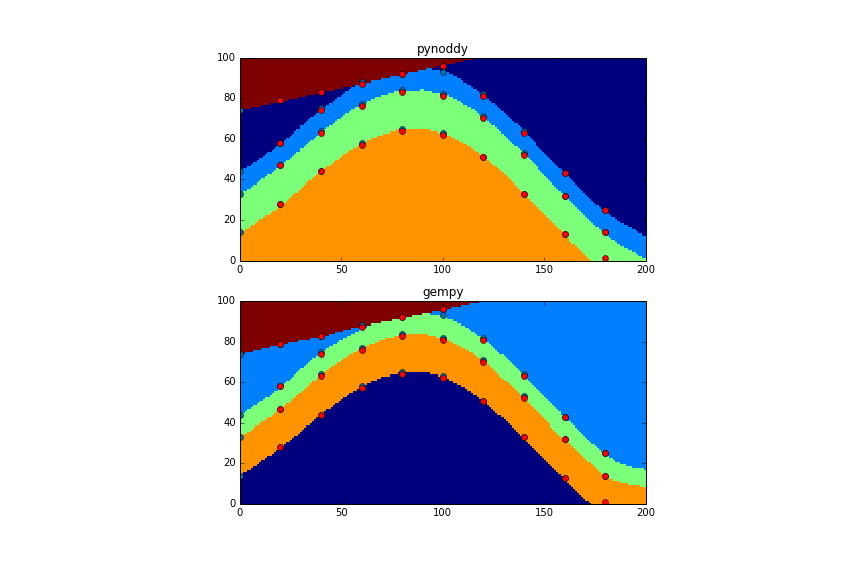

In [15]:
plot_posterior_sections(49)

# Deprecated Code Storage